# __Objective__

To identify the dry season irrigation area in Prey Veng and Svay Rieng, Cambodia across 2000 to 2019 using MODIS satellite product - 16 Days NDVI downloaded from Google Earth Engine. 

The primary objective of this is to compare mapping methodology with Erban and Gorelick (2016) and the weighted sum estimation. The Erban and Gorelick (2016) method utilizes thresholding of 0.55 on maximum NDVI from Jan to March using MODIS - 16 Days NDVI band. The issue is that MODIS pixel area is very large and can contain more than just crops. However, by thresholding, the pixel is considered as being fully irrigated and no irrigated which does not account for fractional irrigated area coverage. 

Hence the method we are proposing is to see if we can estimate the fractional coverage of irrigated area.

The secondary objective is to see the dynamics of irrigated areas across the 19 dry seasons. 

----------------------------------------------------------------------------

# Sections

0. Import libraries

1. Read, conduct and export SG filter on the MODIS 16-Day NDVI into wet & dry seasons and dry seasons datasets.

2. Calculate timestep-wise minimum and maximum NDVI for wet & dry seasons MODIS 16 Days NDVI Timeseries.

3. Derive crops and trees pixels from LULC Dynamic Worldcover into MODIS pixels and  aggregate NDVI values as vegetation and agriculture thresholds.

- 3.1: Derive LULC Dynamic Worldcover pixel coordinates to MODIS coordinates.

- 3.2: Extract and aggregate timestep-wise minimum and maximum NDVI from the derived MODIS pixels.

4. Implement vegetation and agriculture thresholds from crops and trees LULC Dynamic Worldcover images to export agricultural masks regardless of irrigation status.

5. Export reference full coverage and no coverage pixel masks to be used in conjunction with agricultural mask in extracting reference full coverage timeseries and no coverage timeseries.

- 5.1: Derive LULC Dynamic Worldcover counts into MODIS pixels from 2015 - 2019 dry season images dataset.

- 5.2: Delineate full coverage and no coverage masks for each of the exported LULC type counts-derived MODIS pixels. 

- 5.3: Use MODIS full coverage and no coverage mask of each LULC type to look for reference pixels and extract their reference timeseries.

6. Select the monthRange and aggregation combinations of MODIS Full Coverage and No coverage reference pixels.

7. Implement full coverage, no coverage and agricultural masks to extract and aggregate reference full coverage timeseries and reference no coverage timeseries

- 7.1: Extract SG filtered NDVI timeseries that matches the dryseason date of LULC Dynanic Worldcover

- 7.2: Implement full coverage, no coverage and agriculture masks regardless of IA to agregate reference fractional irrigated area coverage timeseries

8.  Use reference full coverage and no coverage to estimate irrigated area.

9. Compare with Erban and Gorelick (2016) method.

- 9.1: Replicate Erban and Gorelick (2016)'s method to Prey Veng and Svay Rieng's late 2000 - early 2019 dry seasons.

- 9.2: Acquire fractional coverage from stable and dynamic reference timeseries and compare their areas together with the Erban and Gorelick (2016) replication. 

- 9.3: Compute the average fractional coverage through time and through agricultural area percentage

- 9.4: Examine Erban and Gorelick (2016) maps

- 9.5: Compare min, median and max Agricultural Percentage against Erban and Gorelick (2016) through time

# ** Special Notes **

The script utilizes large memory and extended amount of time (at least 2 hours) to process pixel-based calculations. Hence the script occasionally save processed data into tif in order to continue the process when restarting the kernel by reading the saved files. Hence, some variables and codes are repeated to facilitate running through code chunks discontinuously. 


------------------------------------------------------------

# __0. Import libraries__

In [1]:
# reading files
import os
import rasterio 
import geopandas as gpd
import pandas as pd

# processing raster
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
import datetime as dt

# read self-defined module
import RemoteSensingProcess as RSP

# visualize raster
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx

-------------------------------------------------------------

#  __1. Read, conduct and export SG filter on the MODIS 16-Day NDVI into wet & dry seasons and dry seasons datasets.__

Read whole year MODIS GEE files and convert DN to NDVI

In [12]:
### Read MODIS NDVI image

# preapre to read tif images
folder = 'MODIS Unscaled NDVI 16 Days 2Provinces Whole Year'
filename_list = [file for file in os.listdir(folder) if 'aux' not in file]
image_NDVI_list = []
image_date_list = []

# iterate through every images in folder to acquire data for 2000-2019 whole year
for filename in filename_list:
    # read file
    date = filename[-14:-4]
    path = os.path.join(folder, filename)
    with rasterio.open(path) as img:
        # extract DN array
        DN_array = img.read(1).astype('float64')
        
        # process nodata value (nodata and -3000)
        DN_array[DN_array == -3000] = np.nan
        DN_array[DN_array == img.nodata] = np.nan

        # scale DN to index value
        NDVI_array = DN_array * 0.0001
        
        # store date and NDVI array
        image_date_list.append(date)
        image_NDVI_list.append(NDVI_array)

# stack NDVI array
stacked_NDVI_MODIS = np.stack(image_NDVI_list, axis = 0) # shape now is (date, row, column)

# replace white space with np.nan
# iterate through row
for row in np.arange(stacked_NDVI_MODIS.shape[1]):
    # iterate through column
    for col in np.arange(stacked_NDVI_MODIS.shape[2]):
        # for white space, replace with np.nan
        if np.nansum(stacked_NDVI_MODIS[:, row, col]) == 0:
            stacked_NDVI_MODIS[:, row, col] = np.full_like(stacked_NDVI_MODIS[:, row, col], np.nan)



Conduct SG filter for smoothing for whole year

In [13]:
### SG filter through time

# define window for SG filter
window = 10

# iterate through pixel (each row and column)
for row in np.arange(stacked_NDVI_MODIS.shape[1]):
    for col in np.arange(stacked_NDVI_MODIS.shape[2]):
        
        # store NDVI timeseries in a variable
        timeseries = stacked_NDVI_MODIS[:, row, col]

        # perform SG filter
        timeseries = signal.savgol_filter(timeseries,window_length=window, polyorder=3, mode="nearest")
        
        # replace it back in the stack
        stacked_NDVI_MODIS[:, row, col] = timeseries

In [14]:
### Add in empty array for early 2000s to complete the full year (MODIS GEE does not have all time step for 2000)

# initialize empty array and corresponding date
nan_array = np.full((3, 482, 493), np.nan) # create array of (3, 482, 493) with nan values
nan_date_list = ['2000-01-01', '2000-01-17', '2000-02-02']

# concatenate stacked NDVI and date list
stacked_NDVI_MODIS = np.concatenate((nan_array, stacked_NDVI_MODIS), axis = 0)
image_date_list = nan_date_list + image_date_list

Export whole year NDVI as single tif

In [7]:
### Export whole year SG filtered MODIS timeseries array 

# acquire and update profile 
with rasterio.open(path) as img:
    profile = img.profile 
    profile['nodata'] = np.nan
    profile['dtype'] = stacked_NDVI_MODIS.dtype
    profile['count'] = stacked_NDVI_MODIS.shape[0]

# export the SG filtered NDVI
out_folder = 'Processed - NDVI timeseries'
os.makedirs(out_folder, exist_ok=True) # make directory if it doesnt exist
filename = f'SG filtered NDVI timeseries -- Whole Year -- {image_date_list[0]}-{image_date_list[-1]} .tif'
with rasterio.open(os.path.join(out_folder, filename), 'w', **profile) as src:
    for index, date in enumerate(image_date_list):
        src.write(stacked_NDVI_MODIS[index], index +1)
        src.set_band_description(index+1, date)

Process and export SG filtered MODIS timeseries array for dry season

** Special note:
- Dry season starts from Novermber and end in March. So it is usually from month 11 to month 4. Going by this satrictly, some season have 11 data points and some has 12 data points. This is because some year has 10-31 and 1 date for November but some has 11-01 and other date for November. Hence, a physically meaningful way to get 12 datapoints is to include 10-31 instead of average month 11 values. 


In [15]:
### Process and export dry season SG filtered MODIS timeseries array

# initialize variable for storing np array and dryseason date
dryseason_stacked_NDVI_MODIS = []
dryseason_image_date_list = [] 

# define keystring to delineate for dry season
dryseason_keystrings = ['10-31', '-11-', '-12-', '-01-', '-02-', '-03-', '-04-']
study_period_keystrings = ['2000-01', '2000-02', '2000-03', '2000-04', '2019-10', '2019-11', '2019-12']

# iterate through date and acquire dryseason images
for index, date in enumerate(image_date_list):
    # define select for and against criteria
    is_dryseason_month = any(keystring in date for keystring in dryseason_keystrings)
    is_study_period = not any(keystring in date for keystring in study_period_keystrings)
    
    # implement criteria
    if is_dryseason_month and is_study_period:
        dryseason_stacked_NDVI_MODIS.append(stacked_NDVI_MODIS[index]) 
        dryseason_image_date_list.append(date)

# stack the dry season NDVI array
dryseason_stacked_NDVI_MODIS = np.stack(dryseason_stacked_NDVI_MODIS, axis = 0)

# export the stack to single tif
# acquire and update profile 
with rasterio.open(path) as img:
    profile = img.profile 
    profile['nodata'] = np.nan
    profile['dtype'] = dryseason_stacked_NDVI_MODIS.dtype
    profile['count'] = dryseason_stacked_NDVI_MODIS.shape[0]

# export the SG filtered NDVI
out_folder = 'Processed - NDVI timeseries'
os.makedirs(out_folder, exist_ok= True) # make dirs if it doesn't exist
filename = f'SG filtered NDVI timeseries -- Dry Season -- {dryseason_image_date_list[0]}-{dryseason_image_date_list[-1]} .tif'
with rasterio.open(os.path.join(out_folder, filename), 'w', **profile) as src:
    for index, date in enumerate(dryseason_image_date_list):
        src.write(dryseason_stacked_NDVI_MODIS[index], index +1)
        src.set_band_description(index+1, date)

---------------------------------------------------------

# __2. Calculate timestep-wise minimum and maximum NDVI for wet & dry seasons MODIS 16 Days NDVI Timeseries__

In [16]:
### Read date excel for modified date, necessary to align MODIS images for calculating max and min per pixel

# Read excel data and turn modified date string into date time format
pixel_df = pd.read_excel('Pixel df.xlsx', sheet_name= 'modified date')
pixel_df['modified date'] = pd.to_datetime(pixel_df['modified date'])

In [17]:
### Extract minimum and maximum NDVI from each pixel

# set up modified date for consistent date for each year (the actual date changes by maximum 1 days for each year)
modified_date = pixel_df.loc[:, 'modified date']

# set up storage array for 23 timestep in a year
unknown_pixel_max_array = np.full((23, 482, 493), np.nan) # create np array of 482 and 493 for 23 times
unknown_pixel_min_array = np.full((23, 482, 493), np.nan) # create np array of 482 and 493 for 23 times

# iterate through pixel (each row and column)
for row in np.arange(stacked_NDVI_MODIS.shape[1]):
    for col in np.arange(stacked_NDVI_MODIS.shape[2]):

        # store NDVI timeseries in a variable
        timeseries = stacked_NDVI_MODIS[:, row, col]

        # ignore non-white space pixel
        if np.nansum(timeseries) != 0:
        
            unknown_pixel_df = pd.DataFrame({
                'modified date': modified_date,
                f'{row},{col}': timeseries
            })

            # extract minmax timeseries dataframe for each pixel
            minmax_timeseries = RSP.NDVI_minmax(unknown_pixel_df, f'{row},{col}')
            
            # extract max NDVI timeseries and append it to unknown_pixel_max_array
            max_timeseries = np.array(minmax_timeseries['max NDVI'])
            unknown_pixel_max_array[:, row, col] = max_timeseries

            # extract min NDVI timeseries and append it to unknown_pixel_min_array
            min_timeseries = np.array(minmax_timeseries['min NDVI'])
            unknown_pixel_min_array[:, row, col] = min_timeseries
            
        

In [18]:
### Export min max timerseries to tif files

# get profile
with rasterio.open(path) as src:
    src_profile = src.profile

# update profile
src_profile['nodata'] = np.nan
src_profile['count'] = 23
src_profile['dtype'] = unknown_pixel_max_array.dtype

# prepare dir output
NDVI_minmax_folder = 'Processed - MODIS Min Max NDVI'
os.makedirs(NDVI_minmax_folder, exist_ok= True) # make folder if it doesn't exist
start_date = image_date_list[0]
end_date = image_date_list[-1]

# export max timeseries NDVI
TimeseriesMax_NDVI_outpath = os.path.join(NDVI_minmax_folder, f'Timeseries Max NDVI {start_date} - {end_date}.tif')
with rasterio.open(TimeseriesMax_NDVI_outpath, 'w', **src_profile) as dst:
    dst.write(unknown_pixel_max_array)

# export min timeseries NDVI
TimeseriesMin_NDVI_outpath = os.path.join(NDVI_minmax_folder, f'Timeseries Min NDVI {start_date} - {end_date}.tif')
with rasterio.open(TimeseriesMin_NDVI_outpath, 'w', **src_profile) as dst:
    dst.write(unknown_pixel_min_array)



-------------------------------------------------------------

# __3. Derive crops and trees pixels from LULC Dynamic Worldcover into MODIS pixels and  aggregate NDVI values as vegetation and agriculture thresholds__

The purpose for this step is to identify which MODIS pixel location contain crops or trees, as indicated by the LULC Dynamic Worldcover. Subsequently, the MODIS NDVI values are extracted and will be used to create vegetation and agriculture thresholds. 


The LULC Dynamic Worldcover has already been processed into the wet & dry seasons 39 images dataset and the dry seasons 23 images dataset in another Jupyter Notebook. The LULC consistency maps were also generated in another Jupyter Notebook. These consistency maps indicated the degrees of pixel-wise monthly agreements in crops and trees classifications ranging from higher than 10% to higher to 50% at 10% intervals. For example, a pixel needs to be classified as crops for at least 7 months to be included in 30% of higher consistency map for the two seasons 39 images dataset. 

The LULC consistency maps is created by layering LULC Dynamic World (exported from GEE) from different months to see how consistent a pixel coordinate is classified as a particular LULC type. For example, taking LULC Dynamic World from 2015-2019 dry season months resulted in 23 months worth of images (a stack of 23 bands). 

The purpose of these consistency maps are to look for pixel locations that can be used for subsequent thresholdings to segregate vegetations and then agriculture. However3, an LULC map from Dynamic Worldcover is not based on Cambodia's ground truth hence the variability in consistency must be allowed. These 10% or higher and 50% or higher ranges from both wet & dry seasons and dry seasons LULC images allow for these variations as well as natural land use changes such as crops turning to bare soil after harvests that could not be captured by taking high consistency percentages. Using this consistency map to mimic ground truth data, a corresponsing MODIS pixel can be located and their NDVI values can be extracted. 

## 3.1 Derive LULC Dynamic Worldcover pixel coordinates to MODIS coordinates

The matching process between LULC Dynamic Worldcover consistency maps and MODIS images is neccessary instead of reprojecting LULC Dynamic Worldcover's 10 meters resolution to align with MODIS's 250 meters resolutions. This is because downscaling LULC maps will lose the LULC type information by aggregating multiple LULC type into 1 dominant type. Instead, a pixel location matching is more ideal, allowing us to know exactly which MODIS pixel has crops and trees. 

In [178]:
### Prepare to read LULC file and match the coordinates to MODIS pixel row and column

# set threshold and LULC type to read
threshold_array = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

LULC_type = ['crops', 'trees', 'bare', 'built']
LULC_period = ['23','39'] 

# define LULC consistency map folder
LULC_consistency_folder = 'LULC Consistency Map'

# obtain file name with no threshold
LULC_filename_list = [file for file in os.listdir(LULC_consistency_folder) if
                      file.endswith('0.tif')]

# define MODIS tif file path to match MODIS pixel
MODIS_filename = 'MODIS Unscaled NDVI 16 Days 2Provinces Whole Year\MODIS 16 Days Unscaled 2Provinces-2000-02-18.tif'

For each of the defined LULC type, number of months and consistency percentage:

1. Implement consistency percentage
2. Match LULUC pixel to MODIS pixel
3. Create mask for matching coordinate
4. Export mask as tif for storage and future ease of access

In [ ]:
### convert LULC pixel coord into MODIS pixel coord

# iterate through LULC period
for period in LULC_period:
    # iterate through LULC type
    for type in LULC_type:
        # select the corresponsing file
        LULC_file = [file for file in LULC_filename_list if
                     period in file and type in file][0]
        
        # read file each file
        LULC_file_path = os.path.join(LULC_consistency_folder, LULC_file)
        
        # iterate through each threshold
        for thres in threshold_array:
        
### Implement thresholding
            # read raster
            with rasterio.open(LULC_file_path) as LULC_img:
                LULC_raster = LULC_img.read(1)
                # Perform thresholding
                LULC_raster_thres = LULC_raster >= thres

### Match LULUC pixel to MODIS pixel
            # Convert thresholded raster into geo coord
            LULC_geo_coord_array = RSP.pixel_geo_coord(LULC_file_path, LULC_raster_thres)
            # Convert geo coord into Modis pixel coord 
            unique_MODIS_pixel_coord_array, counts = RSP.geo_pixel_coord(MODIS_filename,LULC_geo_coord_array)

### Create mask for matching coordinate 
            with rasterio.open(MODIS_filename) as MODIS_img:
                # initialize all false mask
                weighted_mask = np.full(MODIS_img.shape, np.nan)
            # turn the pixel coord's value into True
            weighted_mask[unique_MODIS_pixel_coord_array[:, 0], unique_MODIS_pixel_coord_array[:, 1]] = 1

### Export weighted mask as tif for storage and future ease of access  
            # prepare directory
            outdir_folder = 'Processed - MODIS referece coord mask - agri delineation'
            os.makedirs(outdir_folder, exist_ok= True)
            outdir_filename = f'mask -- {period}-{type}-{thres}.tif'

            # get and update profile
            with rasterio.open(MODIS_filename) as src:
                src_profile = src.profile
                src_profile['dtype'] = weighted_mask.dtype
                src_profile['nodata'] = np.nan
            # export mask array to tif file
            with rasterio.open(os.path.join(outdir_folder, outdir_filename), 'w', **src_profile) as dst:
                dst.write(weighted_mask,1)
            
### Print Notification for completion
            print("Complete:", outdir_filename)

## 3.2 Extract and aggregate timestep-wise minimum and maximum NDVI from the derived MODIS pixels

From Step 2, the minimum and maximum NDVI raster images were generated. The MODIS pixels with crops are used to aggregate maximum NDVI values into vegetation thresholds. The MODIS pixels with trees are used to aggregate minimum NDVI values into agriculture thresholds. There are 3 ways to aggregate NDVI values, mean + standard deviation, mean and mean - standard deviation. Hence:

- number of vegetation thresholds = (10 crops LULC consistency maps, 5 from wet & dry seasons and 5 from dry seasons) * 3 aggregation options 

- number of agriculture thresholds = (10 trees LULC consistency maps, 5 from wet & dry seasons and 5 from dry seasons) * 3 aggregation options

In [2]:
### read min and max NDVI timeseries files

# define max NDVI timeseries variable
max_timeseries_filepath = 'Processed - MODIS Min Max NDVI\Timeseries Max NDVI 2000-01-01 - 2019-12-19.tif'
with rasterio.open(max_timeseries_filepath) as max_timeseries_img:
    max_timeseries_NDVI = max_timeseries_img.read()

# define min NDVI timeseries variable
min_timeseries_filpath = 'Processed - MODIS Min Max NDVI\Timeseries Min NDVI 2000-01-01 - 2019-12-19.tif'
with rasterio.open(min_timeseries_filpath) as min_timeseries_img:
    min_timeseries_NDVI = min_timeseries_img.read()

In [3]:
### read LULC matched-MODIS coordinate mask files

# initialize variable for storage
reference_pixel_dict = {}

# Defining neccessary variables for reading mask file
ref_mask_folder = 'Processed - MODIS referece coord mask - agri delineation'
ref_filename_list = [file for file in os.listdir(ref_mask_folder) if file.endswith('tif')]

# iterate through reference pixel mask file
for ref_filename in ref_filename_list:
    # read file 
    with rasterio.open(os.path.join(ref_mask_folder,ref_filename)) as ref_img:
        ref_pixel_coord_mask = ref_img.read(1)
    # store file
    reference_pixel_dict[ref_filename[8:-4]] = ref_pixel_coord_mask

In [4]:
### Extract minimum and maximum NDVI timeseries for LULC matched_MODIS coordinates to use as references

# initilize storage variable
reference_max_NDVI_timeseries_dict = {}
reference_max_NDVI_threshold_dict = {}
reference_min_NDVI_timeseries_dict = {}
reference_min_NDVI_threshold_dict = {}

# Loop through different combination
for LULC_combination, mask_array in reference_pixel_dict.items():
    
    # generate max threshold
    max_avg_std = RSP.reference_timeseries(mask_array, max_timeseries_NDVI)
    max_threshold = RSP.reference_threshold(max_avg_std['mean'], max_avg_std['std'])
    # store max timeseries and threshold
    reference_max_NDVI_timeseries_dict[LULC_combination] = max_avg_std
    reference_max_NDVI_threshold_dict[LULC_combination] = max_threshold

    # generate min threshold
    min_avg_std = RSP.reference_timeseries(mask_array, min_timeseries_NDVI)
    min_threshold = RSP.reference_threshold(min_avg_std['mean'], min_avg_std['std'])
    # store min timeseries and threshold
    reference_min_NDVI_timeseries_dict[LULC_combination] = min_avg_std
    reference_min_NDVI_threshold_dict[LULC_combination] = min_threshold

-----------------------------------------------------------

# __4. Implement vegetation and agriculture thresholds from crops and trees LULC Dynamic Worldcover images to export agricultural masks regardless of irrigation status__

The first step was selecting for pixels that have the averaged maximum NDVI value equal to or higher than the vegetation threshold. The second step was to select for pixels with the minimum NDVI value equal to or lower than the agriculture thresholds. The first step selected for pixels have NDVI values reflecting vegetations and the second step selected against trees or forests that yield high minimum NDVI atypical of areas with harvested crops or bare soil after harvests. 

This created agricultural masks that can be implemented on the MODIS 16-Day NDVI images to select against non-agriculture pixels

In [5]:
### Use average max and min NDVI to conduct thresholding to select agri pixels regardless of irrigation status

# initialize storage variables to hold vegetation and trees masks
vegetation_mask_dict = {}
agri_mask_dict = {}

# define options for threshold
threshold_dict_options = ['upper', 'mean', 'lower']


# iterate through crops maximum and trees minimum NDVI reference thresholds to acquire vegetation mask and trees mask
for LULC_combination, threshold_dict in reference_max_NDVI_threshold_dict.items():
    # if crops threshold, then implement it with max NDVI 
    if 'crops' in LULC_combination:
        for option in threshold_dict_options:
            vegetation_mask = (np.nanmean(max_timeseries_NDVI, axis = 0) >= threshold_dict[option])
            
            # store mask in dict
            vegetation_mask_dict[f'{LULC_combination}_{option}'] = vegetation_mask

    # if trees threshold, then implement it with min NDVI 
    if 'trees' in LULC_combination:
        for option in threshold_dict_options:
            agri_mask = (np.nanmean(max_timeseries_NDVI, axis = 0) <= threshold_dict[option])

            # store mask in dict
            agri_mask_dict[f'{LULC_combination}_{option}'] = agri_mask

C:\Users\varoc\AppData\Local\Temp\ipykernel_11260\2094721320.py:16: RuntimeWarning: Mean of empty slice
  vegetation_mask = (np.nanmean(max_timeseries_NDVI, axis = 0) >= threshold_dict[option])
C:\Users\varoc\AppData\Local\Temp\ipykernel_11260\2094721320.py:24: RuntimeWarning: Mean of empty slice
  agri_mask = (np.nanmean(max_timeseries_NDVI, axis = 0) <= threshold_dict[option])


In [6]:
### combine vegetation masks and trees masks to create agricultural masks

# initialize storage variable to hold different kinds of agriculture masks

phase1_agri_pixel_mask_dict = {}

# iterate through each vegetation mask and tree mask combination
for vegetation_source ,vegetation_mask in vegetation_mask_dict.items():
    for agri_source, agri_mask in agri_mask_dict.items(): 
        # combine vegetation mask and trees_mask
        phase1_agri_pixel_mask = agri_mask * vegetation_mask
        phase1_agri_pixel_mask = phase1_agri_pixel_mask.astype(np.float64)
        phase1_agri_pixel_mask[phase1_agri_pixel_mask == 0] = np.nan

        # store agriculture mask with corresponding source
        phase1_agri_pixel_mask_dict[f'{vegetation_source}--{agri_source}'] = phase1_agri_pixel_mask

In [7]:
### Print number of maximum and minimum combination
print('Number of maximum and minimum combination:', len(phase1_agri_pixel_mask_dict))

Number of maximum and minimum combination: 900


Select agriculture mask that corresponds to the most accurate agriculture area based on LULC Dynamic World and Census Data.

There are 900 combinations of vegetation and agriculture thresholds from 3 options of reference thresholds arising from 5 options for consistency percentage from the wet & dry seasons and dry seasons. Hence, we have to select the most believable estimates from available sources such as the LULC Dynamic World and the Census Data from The Cambodian Government.

The data from 2013 Census are used to estimated that around 44.12% of the area in the study provinces is devoted to rice and maize (dominant crops). For 2019 census, the percentage is around 38.05%. The LULC Dynamic World's percentages fluctuates from months to months ranging from 0 to about 37%. It is worth noting that the LULC is not accuarate as there are some months that might have cloud cover but is labelled as water. The whitespaces are also labelled as water. We have tried our best to account for this white space but are unable to account for cloud cover effects. 

Hence, the selected ranges are from 35% to 45%. 


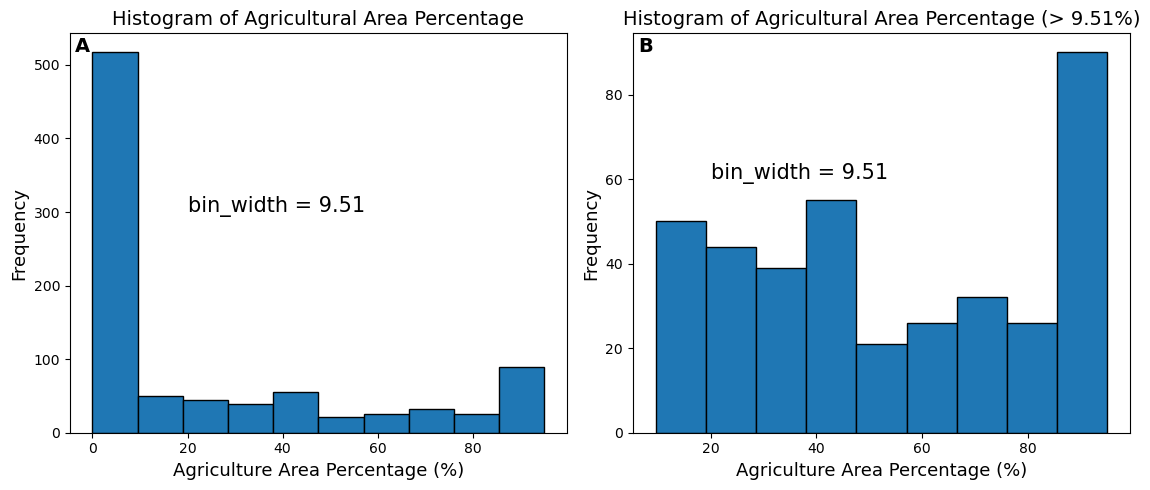

In [8]:
### plot histogram of agricultural areas that all the combinations yield (1 for all and 1 for veg_threshold > agri_threshold)

# define total number of pixels in the MODIS 2 Province
Pro2_total_pixel = 126654

pixel_percentage_list = []

# iterate through all vegetation and trees masks combination
for combination_source, mask_array in phase1_agri_pixel_mask_dict.items():
    
    # implement condition based on LULC Dynamic World and Census Data (within ceratin percentage range)
    vegetation_pixel_percentage = round((np.nansum(mask_array)/Pro2_total_pixel *100), 2) 

    # append pixel percentage to the list for storage
    pixel_percentage_list.append(vegetation_pixel_percentage)

# create histogram using the list with optimal binsize
Q75 = np.quantile(pixel_percentage_list, 0.75)
Q25 = np.quantile(pixel_percentage_list, 0.25)
optbin = 2.1 * (Q75 - Q25) / (len(pixel_percentage_list)**(1/3))

fig, ax = plt.subplots(1, 2, figsize =(11.5,5))

# plot all 900
ax[0].hist(pixel_percentage_list, 
         bins = np.arange(min(pixel_percentage_list), max(pixel_percentage_list) + optbin, optbin),
         edgecolor = 'k')
ax[0].set_title('Histogram of Agricultural Area Percentage', fontsize = 14)
ax[0].set_xlabel('Agriculture Area Percentage (%)', fontsize = 13)
ax[0].set_ylabel('Frequency', fontsize = 13)
xmin, xmax, ymin, ymax = plt.axis()
ax[0].text(20, 300, f'bin_width = {round(optbin, 2)}', fontsize = 15)

# skip first bin
pixel_percentage_list_filtered = [percent for percent in pixel_percentage_list if percent > optbin]
ax[1].hist(pixel_percentage_list_filtered, 
         bins = np.arange(min(pixel_percentage_list_filtered), max(pixel_percentage_list_filtered) + optbin, optbin),
         edgecolor = 'k')
ax[1].set_title(f'Histogram of Agricultural Area Percentage (> {round(optbin,2)}%)', fontsize = 14)
ax[1].set_xlabel('Agriculture Area Percentage (%)', fontsize = 13)
ax[1].set_ylabel('Frequency', fontsize = 13)
xmin, xmax, ymin, ymax = plt.axis()
ax[1].text(20, 60, f'bin_width = {round(optbin, 2)}', fontsize = 15)

ax[0].text(0.01, 0.99, 'A', transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top')
ax[1].text(0.01, 0.99, 'B', transform=ax[1].transAxes, fontsize=14, fontweight='bold', va='top')


plt.tight_layout()

In [39]:
### select agriculture mask that corresponds to the most accurate agriculture area based on LULC Dynamic World and Census Data

# define out folder and MODIS file for image profile for exporting agriculture masks 
agricultureMask_outfolder = 'Processed - Agriculture mask regradless IA'
os.makedirs(agricultureMask_outfolder, exist_ok= True)
MODIS_filepath = 'MODIS Unscaled NDVI 16 Days 2Provinces Whole Year\MODIS 16 Days Unscaled 2Provinces-2000-11-16.tif'

# initialize for storage
selected_pixel_percentage_list = []

# iterate through all vegetation and trees masks combination
for combination_source, mask_array in phase1_agri_pixel_mask_dict.items():

    # implement condition based on LULC Dynamic World and Census Data (within ceratin percentage range)
    vegetation_pixel_percentage = round((np.nansum(mask_array)/Pro2_total_pixel *100), 2) 
    if vegetation_pixel_percentage >= 35 and vegetation_pixel_percentage <= 45:
        
        # store percentage 
        selected_pixel_percentage_list.append(vegetation_pixel_percentage)

        # export agriculture masks based on earlier condition
        agricultureMask_outname = f'Agriculture mask regardless IA -- {vegetation_pixel_percentage}% -- {combination_source}.tif'
        agricultureMask_outpath = os.path.join(agricultureMask_outfolder, agricultureMask_outname)
        agricultureMask_description = f'{vegetation_pixel_percentage}% -- {combination_source}'
        RSP.band_export(MODIS_filepath, agricultureMask_outpath, mask_array, agricultureMask_description)


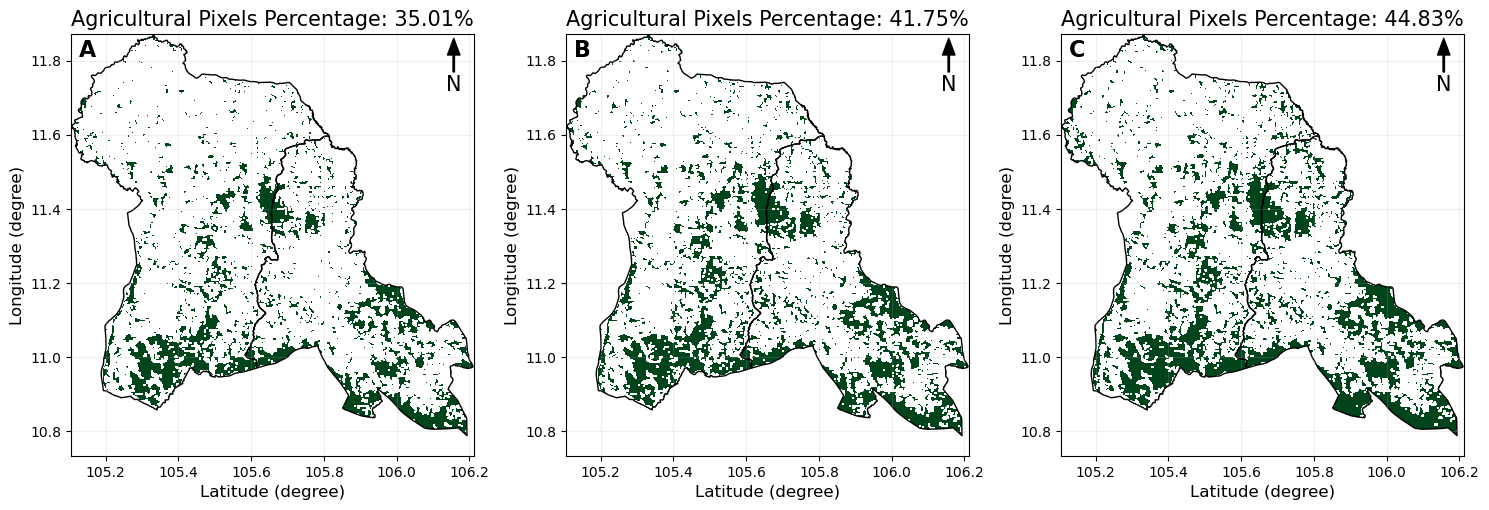

In [258]:
# plot max, median and min agricultural area percentage


# prepare boundary file
# read shapefile
study_boundary = gpd.read_file('Study Area Boundary Polygon\Double Province Boundary\Province_Boundary.shp')
# Reproject to EPSG 4326 (WGS 84)
study_boundary = study_boundary.to_crs(epsg=4326)


# perpare to read file
max_percent = max(selected_pixel_percentage_list)
median_percent = np.median(selected_pixel_percentage_list)
min_percent = min(selected_pixel_percentage_list)

filenames = [file for file in os.listdir(agricultureMask_outfolder) 
             if file.endswith('.tif') and
             (str(max_percent) in file or str(median_percent) in file or str(min_percent) in file)]

labels = ['A', 'B', 'C']

fig, ax = plt.subplots(1, 3, figsize = (15, 30))

for index, filename in enumerate(filenames):

    path = os.path.join(agricultureMask_outfolder, filename)

    with rasterio.open(path) as img:
        # plot raster
        show(img, ax = ax[index], cmap = 'Greens_r')

    # plot boundary
    study_boundary.plot(ax = ax[index], edgecolor = 'k', facecolor = 'none')


    # aesthetics
    ax[index].set_ylabel('Longitude (degree)', fontsize = 12)
    ax[index].set_xlabel('Latitude (degree)', fontsize = 12)
    ax[index].set_title(f'Agricultural Pixels Percentage: {filename.split()[5]}', fontsize = 15)
    ax[index].grid(alpha = 0.2)

    # add arrow
    x, y, arrow_length = 0.95, 0.99, 0.11
    ax[index].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=1, headwidth=9),
                ha='center', va='center', fontsize=15,
                xycoords=ax[index].transAxes)

    # plot label
        # Label the subplots
    ax[index].text(0.02, 0.99, labels[index], transform=ax[index].transAxes,
                  fontsize=16, fontweight='bold', va='top', color='k')

plt.tight_layout()


-------------------------------------------------

# __5. Export reference full coverage and no coverage pixel masks to be used in conjunction with agricultural mask in extracting reference full coverage timeseries and no coverage timeseries__

## 5.1 Derive LULC Dynamic Worldcover counts into MODIS pixels from 2015 - 2019 dry season images dataset.

In order to delineate which MODIS pixel has full coverage or no coverage during the dry season, a LULC count images can be made from the dry season 23 images LULC Dynamic worldcover dataset. The count images values indicate how many LULC pixels of a particular LULC type are in a MODIS pixel. A MODIS pixel can hold 625 LULC pixels hence, the crops count value of 625 can be used to delineate if a MODIS pixel has full crops during the dry season. 

This substep turns the dry season 23 monthly LULC images into 23 monthly count images with MODIS's 250 m resolution.

In [2]:
### Prepare list to read LULC stack raster and export count raster

# prepare to read stack
LULC_stack_folder = 'LULC Type Stack'
LULC_stack_filename_list = [file for file in os.listdir(LULC_stack_folder) if file.endswith('.tif')] 

# prepare to convert geo coord to MODIS coord and count array
MODIS_filepath = 'MODIS Unscaled NDVI 16 Days 2Provinces Whole Year\MODIS 16 Days Unscaled 2Provinces-2000-11-16.tif'
with rasterio.open('Processed - NDVI timeseries\SG filtered NDVI timeseries -- Dry Season -- 2000-10-31-2019-04-23 .tif')as img:
    MODIS_NDVI_file_with_nan = img.read(6)

In [ ]:
### Iterate through each LULC type stack
for LULC_stack_name in LULC_stack_filename_list[2:]:
    # get LULC type
    LULC_type = (LULC_stack_name.split()[1])
    
    # get path for LULC stack images
    LULC_stack_path = os.path.join(LULC_stack_folder, LULC_stack_name)

    # convert LULC stack of specified type's pixel coordinate to geo coord 
    LULC_geo_coord_dict = RSP.LULCstack_to_LULC_coord(LULC_stack_path, LULC_type, notification= True) # keys are LULC date and values are geo coord 

    # convert LULC geo coord to Modis count array
    MODIS_type_stack = RSP.LULC_coordDict_MODIS_count(MODIS_filepath, LULC_geo_coord_dict, notification= True)
    MODIS_type_stack = RSP.add_noCoverage(MODIS_type_stack, MODIS_NDVI_file_with_nan)

    # export modis-lulc type count tif
    count_outfolder = 'Processed - MODIS Count'
    os.makedirs(count_outfolder, exist_ok= True)
    count_outname = f'LULC matched-MODIS {LULC_type} count raster.tif'
    count_outpath = os.path.join(count_outfolder, count_outname)
    RSP.count_raster_export(MODIS_filepath, count_outpath, MODIS_type_stack, LULC_geo_coord_dict.keys())
    
    # notify completion
    print(f'{LULC_type}: complete')

# delete large file from memory
del LULC_geo_coord_dict, MODIS_type_stack

## 5.2 Delineate full coverage and no coverage masks for each of the exported LULC type counts-derived MODIS pixels.

After obtaining the count images, the MODIS pixel locations with full coverage (625) or no coverage (0) can be identified and selected. This is done by mapping each LULC pixels to the corresponsing MODIS pixel locations. Since a MODIS pixel is larger than a LULC pixel, a MODIS pixel that contains multiple LULC pixels will get flagged multiple times up to 625 times. 

This substep process 23 monthly counts images with MODIS's 250 m resolution into 23 monthly MODIS's 250 m resolution with either full coverage or no coverage mask for each specified LULC type. The interesed LULC type are:

- crops
- bare
- trees
- grass
- shrub and scrubs

The mask contains values of 1 and np.nan with 1 in pixel locations with full or no coverage and np.nan for all other pixel locations.

In [4]:
#### Prepare to read count raster and compress count
count_raster_folder = 'Processed - MODIS Count'
count_raster_filenames = [file for file in os.listdir(count_raster_folder) if file.endswith('.tif')]
selected_month_list = [
    ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
    ['Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
    ['Jan', 'Feb', 'Mar', 'Apr']
]

# define MODIS filepath for export
MODIS_filepath ='MODIS Unscaled NDVI 16 Days 2Provinces Whole Year\\MODIS 16 Days Unscaled 2Provinces-2000-11-16.tif'

In [5]:
### Full coverage: Iterate through combination to export full coverage coordinate
for count_raster_filename in count_raster_filenames:
    for selected_month in selected_month_list:
        
        # obtain path
        count_raster_filepath = os.path.join(count_raster_folder, count_raster_filename)        

        # filter for full coverage
        filtered_stack, stack_date = RSP.filter_coverage(count_raster_filepath, 'more-equal', 625)

        # Obtain selected month key strings
        selected_month_keystrings = RSP.dryMonth_keystring_selection(selected_month) 

        # Compress monthly MODIS full coverage arrays into single array for each dry season from 2015 - 2019
        compressed_stack, compressed_date = RSP.extract_monthly_coverage(filtered_stack, stack_date, "any", selected_month_keystrings)
        
        ### export stack
        count_outfolder = 'Processed - MODIS Coverage Mask per season'
        os.makedirs(count_outfolder, exist_ok= True)
        # define name
        lulc_type = count_raster_filename.split()[2]
        count_outname = f'Full coverage {lulc_type} per season -- {selected_month[0]}-{selected_month[-1]} .tif'
        # define path
        count_outpath = os.path.join(count_outfolder, count_outname)
        RSP.count_raster_export(MODIS_filepath, count_outpath, compressed_stack, compressed_date)


In [6]:
### No coverage: Iterate through combination to export no coverage coordinate
for count_raster_filename in count_raster_filenames:
    for selected_month in selected_month_list:
        
        # obtain path
        count_raster_filepath = os.path.join(count_raster_folder, count_raster_filename)        

        # filter for no coverage
        filtered_stack, stack_date = RSP.filter_coverage(count_raster_filepath, 'equal', 0)

        # Obtain selected month key strings
        selected_month_keystrings = RSP.dryMonth_keystring_selection(selected_month) 

        # Compress monthly MODIS full coverage arrays into single array for each dry season from 2015 - 2019
        compressed_stack, compressed_date = RSP.extract_monthly_coverage(filtered_stack, stack_date, "all", selected_month_keystrings)
        
        ### export stack
        count_outfolder = 'Processed - MODIS Coverage Mask per season'
        os.makedirs(count_outfolder, exist_ok= True)
        # define name
        lulc_type = count_raster_filename.split()[2]
        count_outname = f'No coverage {lulc_type} per season -- {selected_month[0]}-{selected_month[-1]} .tif'
        # define path
        count_outpath = os.path.join(count_outfolder, count_outname)
        RSP.count_raster_export(MODIS_filepath, count_outpath, compressed_stack, compressed_date)


## 5.3 Use MODIS full coverage and no coverage mask of each LULC type to look for reference pixels and extract their reference timeseries

Extract and combine full coverage mask and no coverage mask to obtain reference pixel locations for full coverage and no coverage. These pixels will then be used to aggregate and construct reference timeseries for fulll coverage and no coverage.

- For full coverage, we will need to test full crop masks created from Nov-Apr (dry season months), Dec-Apr (months exclusive to the dry season) and Jan-Apr (the harvesting period months). This means that in the pixels that have full crops any of the specified months will be used to construct reference full coverage timeseries. 

- For no coverage, we will be using a combination of full bare, no crops and no trees mask, no grass, and no shrubs_and_scrubs masks. This no coverage combination masks will be tested for Nov-Apr (the entire dry season) and Dec-Apr (dry season exclusive months). This means that only the pixels that have full bare or no crops, no trees, no grass and no shrub_and_scrub for the entire duration of the specified months will be used to construct no coverage timeseries. We also purposely ignore Jan-Apr since there may be a chance that Nov and Dec have some crops or trees and may confound our analysis for no coverage. 

In [44]:
### Define and initialize mask coverage mask dir and storage variable
coverageMask_folder = 'Processed - MODIS Coverage Mask per season'

In [45]:
### Obtain full coverage masks by obtaining different month combinations of full crops mask

full_coverage_monthCombination_list = ['Nov-Apr','Dec-Apr', 'Jan-Apr'] # can add more month ranges such as 'Jan-Mar'
full_coverage_dict = RSP.multi_month_coverage_mask_selection(coverageMask_folder, 'crops', 'full') 

# store only the mask array, discarding date 
full_coverage_dict = {key: full_coverage_dict[key]['array'] for key in full_coverage_monthCombination_list}

In [46]:
### Obtain no coverage masks by taking full bare or (no crops and no trees and no grass and no shrub_and_scrub)
# 1. combining no coverage into no vegetation (pixel must be all True in all no coverage mask)
# 2. combining full bare and no vegetation (pixel must be all True in either no vegetation mask or full bare mask)

# define dictionary for storage
no_coverage_dict = {}

# define monthRange for no coverage
no_coverage_monthRange_list = ['Nov-Apr', 'Dec-Apr'] # can add more Month ranges such as 'Dec-Apr'

### 1. combining several coverage mask related to vegetation to get no vegetation mask 

# define LULC type combination for no coverage
no_vegetation_coverage_LULC_list = ['crops', 'trees', 'grass', 'shrub_and_scrub']

# define no vegetation mask dict to store only no vegetation mask to be later combined with full bare mask
no_vegetation_dict = {}

# iterate through no vegetation-related masks for each month range
for monthRange in no_coverage_monthRange_list:
    
    # define temporary list to hold the uncombined no coverage masks for a particular monthRange
    uncombined_no_vegetation_coverage_mask_list = []

    for coverage_LULC_combination in no_vegetation_coverage_LULC_list:

        # define coverage type and LULC type
        coverage_type = coverage_LULC_combination[0]
        LULC_type = coverage_LULC_combination[1]
        
        # acquire dictionary with mask from desired month range 
        no_coverage_array = RSP.multi_month_coverage_mask_selection(coverageMask_folder, LULC_type, 'no')[monthRange]['array']
        
        # store it in the uncombined mask list
        uncombined_no_vegetation_coverage_mask_list.append(no_coverage_array)
    
    # once all coverage mask have been acquired, combine them 
    combined_no_vegetation_coverage_mask_array = np.stack(uncombined_no_vegetation_coverage_mask_list, axis = 0)
    combined_no_vegetation_coverage_mask_array = np.all(combined_no_vegetation_coverage_mask_array == 1, axis = 0).astype(np.float32)
    combined_no_vegetation_coverage_mask_array[combined_no_vegetation_coverage_mask_array == 0] = np.nan
    
    # store the combined mask in dict with corresponding monthRange
    no_vegetation_dict[monthRange] = combined_no_vegetation_coverage_mask_array

### 2. Combine full bare and no vegetation masks to get no coverage mask

# iterate through month range
for monthRange in no_coverage_monthRange_list:
    # obtain both full bare and no vegetation mask array for each month range
    full_bare_mask_array = RSP.multi_month_coverage_mask_selection(coverageMask_folder, 'bare', 'full')[monthRange]['array']
    no_vegetation_mask_array = no_vegetation_dict[monthRange]

    # combine full bare mask array with no vegetation mask array 
    no_coverage_array = np.stack((full_bare_mask_array, no_vegetation_mask_array), axis = 0)
    no_coverage_array = np.any(no_coverage_array == 1, axis = 0).astype(np.float32)
    no_coverage_array[no_coverage_array == 0] = np.nan

    # store no coverage mask in dict
    no_coverage_dict[monthRange] =  no_coverage_array

# remove confusing variable created in this code chunk 
del no_vegetation_dict, no_coverage_array, uncombined_no_vegetation_coverage_mask_list
del combined_no_vegetation_coverage_mask_array, full_bare_mask_array, no_vegetation_mask_array

---------------------------------------------------------

# __6. Select the monthRange and aggregation combinations of MODIS Full Coverage and No coverage reference pixels__

Currently, for a given agricultural mask, there is 3 combination of LULC derived full coverage and no coverage. 3 for full coverage which are 'Nov-Apr', 'Dec-Apr', and 'Jan-Apr'. We have 2 for no coverage which are 'Nov-Apr' and 'Dec-Apr'. We need to narrow down which full and no coverage month range is the most appropriate by compring all with a pilot/prototype agricultural mask. If the reference full and no coverage timeseies do not differ by much, then we will use the Dec-Apr as it eliminates possible confounding factors from residual wet season cultivations in November.  

We will pilot with the highest agricultural area mask (step 4's GeoTIF export that is the closest to 45%). The selected monthRange full and no coverage pixels will be selected for and any other pixels will be selected against. The full and no coberage pixels are transferred to the MODIS 16-Day NDVI images where the NDVI timeseries can be extracted and aggregated to form the reference full and no coverage timeseries. 

The aggregation process can be done with mean + standard deviation, mean, and mean - standard deviation. Plotting out 3 possible aggregation for each monthRange can help us decide which one is the best.



In [47]:
# prepre to read the lowest agricultural area and the highesy agricultural area masks
pilot_agri_mask_folder = 'Processed - Agriculture mask regradless IA'
pilot_agri_mask_filenames = [file for file in os.listdir(pilot_agri_mask_folder) if file.endswith('.tif')]
pilot_agri_mask_filename = pilot_agri_mask_filenames[-1]

# read mask
with rasterio.open(os.path.join(pilot_agri_mask_folder, pilot_agri_mask_filename)) as img:
    agriculturalMask_array = img.read()

In [48]:
### Read NDVI array and extract only the dry season date that corresponds to LULC Dynamicworld

# read dry season SG filtered MODIS NDVI images 
with rasterio.open('Processed - NDVI timeseries\SG filtered NDVI timeseries -- Dry Season -- 2000-10-31-2019-04-23 .tif') as drySeason_NDVI_img:
    drySeason_NDVI_raster = drySeason_NDVI_img.read()
    drySeason_NDVI_date = drySeason_NDVI_img.descriptions

# initialize variables to store LULC date matched MODIS NDVI bands 
LULC_matched_time_NDVI = []
LULC_matched_time_NDVI_date = []

# define keystring for selecting for and against years and months not matching LULC Dynamic World
LULC_matched_keystring = ['2015', '2016', '2017', '2018', '2019']
not_LULC_matched_keystring = ['2015-01', '2015-02', '2015-03', '2015-04', '2019-11', '2019-12']

# filter only the LULC matched dry season months 
for index, date in enumerate(drySeason_NDVI_date):
    # look for desired months and date
    is_LULC_matched_MD = any(key_string in date for key_string in LULC_matched_keystring)

    # select against undesired years
    is_LULC_matched_year = all(key_string not in date for key_string in not_LULC_matched_keystring)

    # afilter for LULC matched date 
    if is_LULC_matched_MD and is_LULC_matched_year:    
        LULC_matched_time_NDVI.append(drySeason_NDVI_raster[index, :, :])
        LULC_matched_time_NDVI_date.append(date)

# stack the NDVI array
LULC_matched_time_NDVI = np.stack(LULC_matched_time_NDVI, axis = 0)

### separate NDVI array into each dry season that match LULC year 
# inintialize variable to store 
LULC_matched_season_NDVI_dict = {}

# filter for each LULC matched period (every 12 date in a dry season)
for index in range(0, len(LULC_matched_time_NDVI_date), 12):
    
    # obtain time range
    start_year = LULC_matched_time_NDVI_date[index][:4]
    end_year = LULC_matched_time_NDVI_date[index+11][:4]
    LULC_matched_period = f'{start_year}-{end_year}'
    
    # store array
    LULC_matched_season_NDVI_dict[LULC_matched_period] = LULC_matched_time_NDVI[index:index+12, :, :]

# remove dryseason SG filtered NDVI timeseries and date from memory

del drySeason_NDVI_raster, drySeason_NDVI_date, LULC_matched_time_NDVI, LULC_matched_time_NDVI_date

In [49]:
### Use masks to obtain reference full coverage timeseries 

# initialize dictionary for storage for every agriculturalMask and full coverage mask combination
raw_full_IA_timeseries_dict = {} # this will be turned into a nested dictionary (a dict inside a dict)
full_IA_timeseries_dict = {}

## Iterate through full coverage dict to acquire full coverage reference timeseries ##
for monthRange, full_coverage_array in full_coverage_dict.items():

### Process reference timeseries for every full coverage masks and agricultural mask combination ###

    full_IA_timeseries_dict[monthRange]= []
    
    # Initialize storage variable for each season
    allSeason_reference_timeseries_list = []

    ## iterate through every LULC match season (4 dryseason period in this case) ##
    for dryseason_index, date in enumerate(LULC_matched_season_NDVI_dict.keys()):

        # acquire the NDVI array for the season
        dryseasonal_NDVI_array = LULC_matched_season_NDVI_dict[date]

        # acquire and duplicate full coverage mask to fit agriculturalMask_array
        dryseasonal_full_coverage_array = full_coverage_array[dryseason_index] # obtain array corresponding to the dryseason period
        dryseasonal_full_coverage_array = np.expand_dims(dryseasonal_full_coverage_array, axis = 0)

        # combine agricultural mask and full coverage mask  and get the pixel coordinates
        dryseasonal_full_agriculture_mask = dryseasonal_full_coverage_array * agriculturalMask_array
        row_indices, col_indices = np.where(~np.isnan(dryseasonal_full_agriculture_mask[0]))
        
        # Obtain reference full coverage IA timeseries for a season ##
        dryseasonal_timeseries_pixel_reference = dryseasonal_NDVI_array[:, row_indices, col_indices]

        # store seasonal reference timeseries 
        allSeason_reference_timeseries_list.append(dryseasonal_timeseries_pixel_reference)

    # stack and average once we have all the dryseason timeseries
    allSeason_reference_timeseries_list = np.concatenate(allSeason_reference_timeseries_list, axis = 1)

    # define combination 
    #  combination = f'{agriculturalMask_info}-{monthRange}'
    
    # store raw timesereies count
    raw_full_IA_timeseries_dict[monthRange] = allSeason_reference_timeseries_list
    
    # store summarized timeseries
    full_IA_timeseries_dict[monthRange].append(RSP.raw_reference_timeseries(allSeason_reference_timeseries_list)['upper'])
    full_IA_timeseries_dict[monthRange].append(RSP.raw_reference_timeseries(allSeason_reference_timeseries_list)['mean'])
    full_IA_timeseries_dict[monthRange].append(RSP.raw_reference_timeseries(allSeason_reference_timeseries_list)['lower'])

In [50]:
### Use masks to obtain reference no coverage timeseries 

# initialize dictionary for storage for every agriculturalMask and full coverage mask combination
raw_no_IA_timeseries_dict = {}
no_IA_timeseries_dict = {}

## Iterate through full coverage dict to acquire full coverage reference timeseries ##
for monthRange, no_coverage_array in no_coverage_dict.items():

### Process reference timeseries for every full coverage masks and agricultural mask combination ###

    no_IA_timeseries_dict[monthRange] = []

    # Initialize storage variable for each season
    allSeason_reference_timeseries_list = []

    ## iterate through every LULC match season (4 dryseason period in this case) ##
    for dryseason_index, date in enumerate(LULC_matched_season_NDVI_dict.keys()):

        # acquire the NDVI array for the season
        dryseasonal_NDVI_array = LULC_matched_season_NDVI_dict[date]

        # acquire and duplicate full coverage mask to fit agriculturalMask_array
        dryseasonal_no_coverage_array = no_coverage_array[dryseason_index] # obtain array corresponding to the dryseason period
        dryseasonal_no_coverage_array = np.expand_dims(dryseasonal_no_coverage_array, axis = 0)

        # combine agricultural mask and full coverage mask  and get the pixel coordinates
        dryseasonal_no_agriculture_mask = dryseasonal_no_coverage_array * agriculturalMask_array
        row_indices, col_indices = np.where(~np.isnan(dryseasonal_no_agriculture_mask[0]))
        
        # Obtain reference full coverage IA timeseries for a season ##
        dryseasonal_timeseries_pixel_reference = dryseasonal_NDVI_array[:, row_indices, col_indices]

        # store seasonal reference timeseries 
        allSeason_reference_timeseries_list.append(dryseasonal_timeseries_pixel_reference)

    # stack and average once we have all the dryseason timeseries
    allSeason_reference_timeseries_list = np.concatenate(allSeason_reference_timeseries_list, axis = 1)

    # store raw timesereies count 
    raw_no_IA_timeseries_dict[monthRange] = allSeason_reference_timeseries_list

    # store summarized timeseries
    no_IA_timeseries_dict[monthRange].append(RSP.raw_reference_timeseries(allSeason_reference_timeseries_list)['upper'])
    no_IA_timeseries_dict[monthRange].append(RSP.raw_reference_timeseries(allSeason_reference_timeseries_list)['mean'])
    no_IA_timeseries_dict[monthRange].append(RSP.raw_reference_timeseries(allSeason_reference_timeseries_list)['lower'])


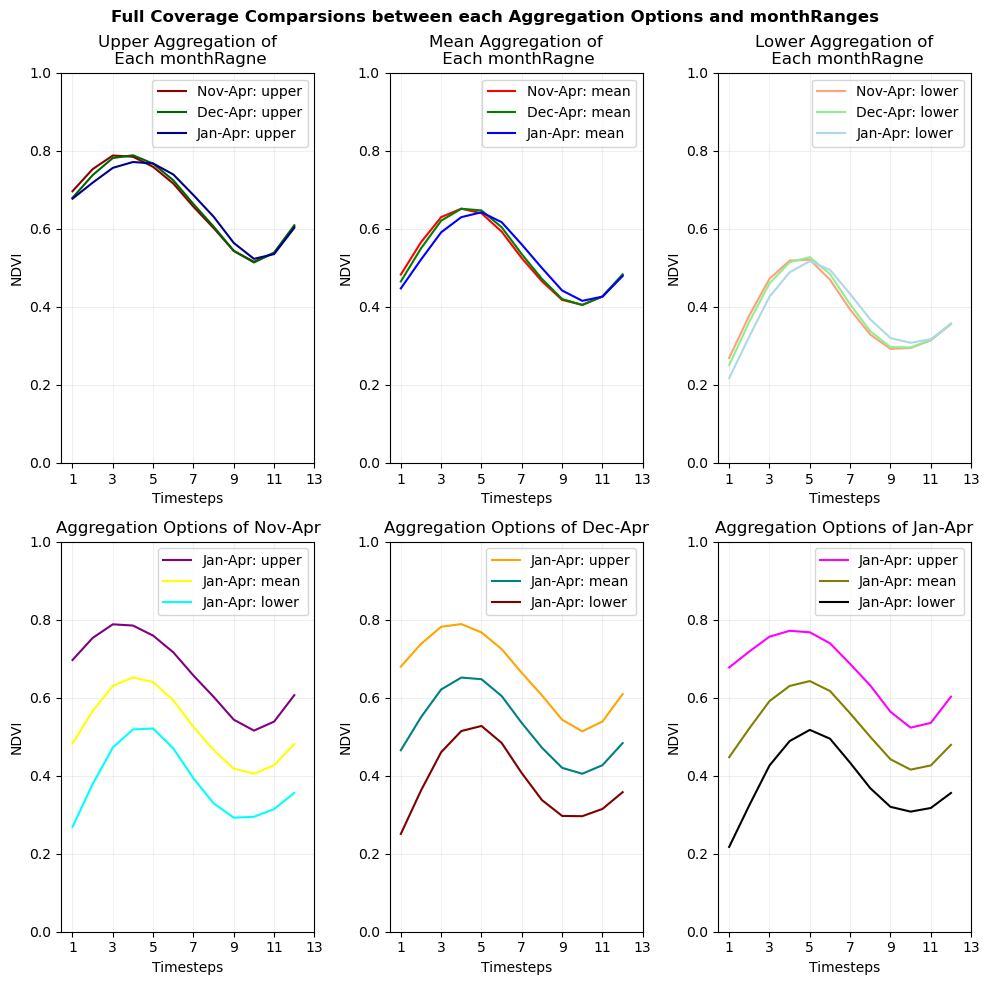

In [51]:
### Plot to compare full coverage

timestep_list = np.arange(1, 13)

fig, ax = plt.subplots(2,3, figsize = (10,10))

ax = ax.flatten()

# plot for upper, comparing betweeen monthRange
monthRange_color = ['DarkRed', 'DarkGreen', 'DarkBlue']
for month_index, monthRange in enumerate(full_IA_timeseries_dict.keys()):
    for index, stats in enumerate(['upper', 'mean', 'lower']):
        if stats == 'upper':
            ax[0].plot(timestep_list, full_IA_timeseries_dict[monthRange][index], label = f'{monthRange}: upper',
                       color = monthRange_color[month_index])    
ax[0].set_title('Upper Aggregation of\n Each monthRagne')

# plot for mean, comparing betweeen monthRange
monthRange_color = ['red', 'green', 'blue']
for month_index, monthRange in enumerate(full_IA_timeseries_dict.keys()):
    for index, stats in enumerate(['upper', 'mean', 'lower']):
        if stats == 'mean':
            ax[1].plot(timestep_list, full_IA_timeseries_dict[monthRange][index], label = f'{monthRange}: mean',
                       color = monthRange_color[month_index])    
ax[1].set_title('Mean Aggregation of\n Each monthRagne')

# plot for lower, comparing betweeen monthRange
monthRange_color = ['LightSalmon', 'LightGreen', 'LightBlue']
for month_index, monthRange in enumerate(full_IA_timeseries_dict.keys()):
    for index, stats in enumerate(['upper', 'mean', 'lower']):
        if stats == 'lower':
            ax[2].plot(timestep_list, full_IA_timeseries_dict[monthRange][index], label = f'{monthRange}: lower',
                       color = monthRange_color[month_index])    
ax[2].set_title('Lower Aggregation of\n Each monthRagne')

# plot for Nov-Apr: comparing upper, mean and lower
NovApr_color = ['purple', 'yellow', 'cyan']
for index, stats in enumerate(['upper', 'mean', 'lower']):
        ax[3].plot(timestep_list, full_IA_timeseries_dict['Nov-Apr'][index], label = f'{monthRange}: {stats}', 
                   color = NovApr_color[index]) 
ax[3].set_title('Aggregation Options of Nov-Apr')

# plot for Dec-Apr: comparing upper, mean and lower
DecApr_color = ['orange', 'teal', 'maroon']
for index, stats in enumerate(['upper', 'mean', 'lower']):
        ax[4].plot(timestep_list, full_IA_timeseries_dict['Dec-Apr'][index], label = f'{monthRange}: {stats}',
                   color = DecApr_color[index]) 
ax[4].set_title('Aggregation Options of Dec-Apr')


# plot for Jan-Apr: comparing upper, mean and lower
JanApr_color = ['magenta', 'olive', 'k']
for index, stats in enumerate(['upper', 'mean', 'lower']):
        ax[5].plot(timestep_list, full_IA_timeseries_dict['Jan-Apr'][index], label = f'{monthRange}: {stats}',
                   color = JanApr_color[index]) 
ax[5].set_title('Aggregation Options of Jan-Apr')


# plot aesthetics

for ax_index in range(len(ax)):  
    ax[ax_index].legend()
    ax[ax_index].set_ylabel('NDVI')
    ax[ax_index].set_xlabel('Timesteps')
    ax[ax_index].set_xticks(np.arange(1, 14, 2))
    ax[ax_index].set_ylim(0,1)
    ax[ax_index].grid(alpha = 0.2)
plt.suptitle('Full Coverage Comparsions between each Aggregation Options and monthRanges', weight = 'bold')
plt.tight_layout()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


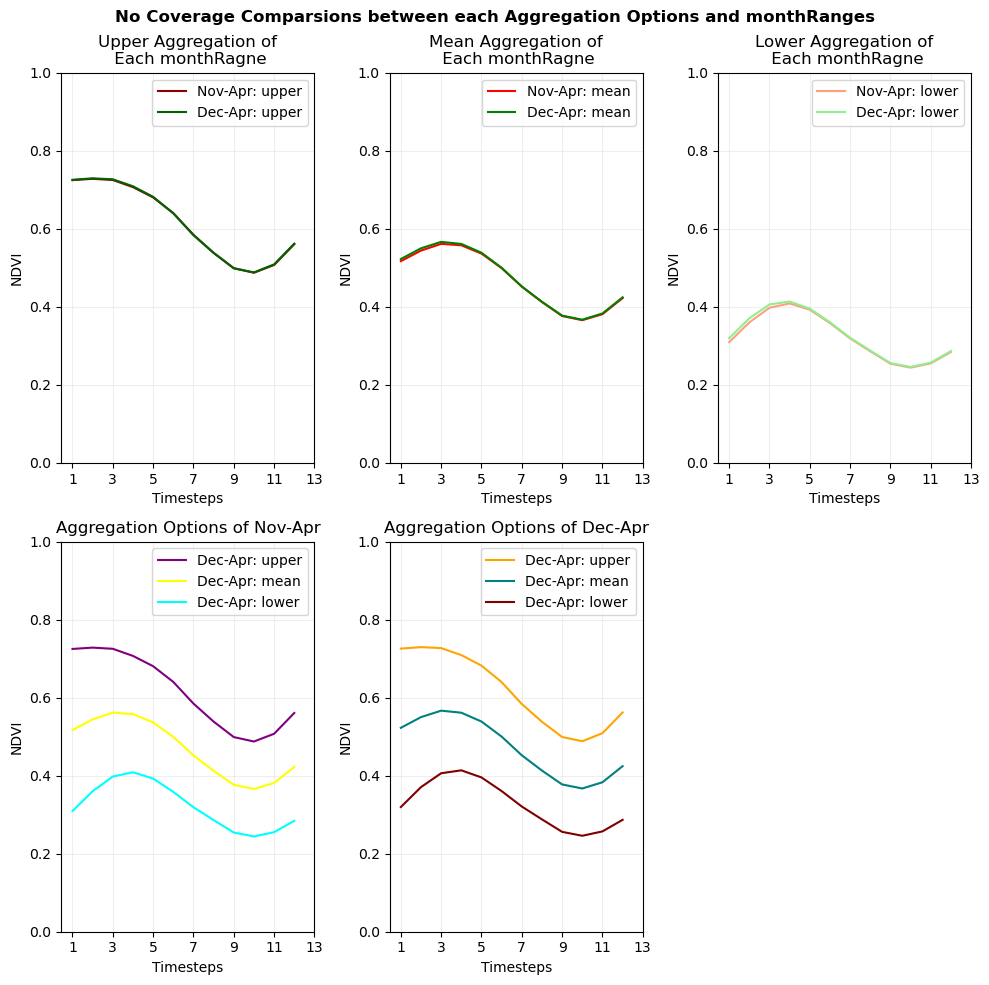

In [52]:
### Plot for no coverage

timestep_list = np.arange(1, 13)

fig, ax = plt.subplots(2,3, figsize = (10,10))

ax = ax.flatten()

# plot for upper, comparing betweeen monthRange
monthRange_color = ['DarkRed', 'DarkGreen']
for month_index, monthRange in enumerate(no_IA_timeseries_dict.keys()):
    for index, stats in enumerate(['upper', 'mean', 'lower']):
        if stats == 'upper':
            ax[0].plot(timestep_list, no_IA_timeseries_dict[monthRange][index], label = f'{monthRange}: upper',
                       color = monthRange_color[month_index])    
ax[0].set_title('Upper Aggregation of\n Each monthRagne')

# plot for mean, comparing betweeen monthRange
monthRange_color = ['red', 'green']
for month_index, monthRange in enumerate(no_IA_timeseries_dict.keys()):
    for index, stats in enumerate(['upper', 'mean', 'lower']):
        if stats == 'mean':
            ax[1].plot(timestep_list, no_IA_timeseries_dict[monthRange][index], label = f'{monthRange}: mean',
                       color = monthRange_color[month_index])    
ax[1].set_title('Mean Aggregation of\n Each monthRagne')

# plot for lower, comparing betweeen monthRange
monthRange_color = ['LightSalmon', 'LightGreen']
for month_index, monthRange in enumerate(no_IA_timeseries_dict.keys()):
    for index, stats in enumerate(['upper', 'mean', 'lower']):
        if stats == 'lower':
            ax[2].plot(timestep_list, no_IA_timeseries_dict[monthRange][index], label = f'{monthRange}: lower',
                       color = monthRange_color[month_index])    
ax[2].set_title('Lower Aggregation of\n Each monthRagne')

# plot for Nov-Apr: comparing upper, mean and lower
NovApr_color = ['purple', 'yellow', 'cyan']
for index, stats in enumerate(['upper', 'mean', 'lower']):
        ax[3].plot(timestep_list, no_IA_timeseries_dict['Nov-Apr'][index], label = f'{monthRange}: {stats}', 
                   color = NovApr_color[index]) 
ax[3].set_title('Aggregation Options of Nov-Apr')

# plot for Dec-Apr: comparing upper, mean and lower
DecApr_color = ['orange', 'teal', 'maroon']
for index, stats in enumerate(['upper', 'mean', 'lower']):
        ax[4].plot(timestep_list, no_IA_timeseries_dict['Dec-Apr'][index], label = f'{monthRange}: {stats}',
                   color = DecApr_color[index]) 
ax[4].set_title('Aggregation Options of Dec-Apr')


# remove last plot
# Remove the last subplot entirely
fig.delaxes(ax[5])


# plot aesthetics

for ax_index in range(len(ax)):  
    ax[ax_index].legend()
    ax[ax_index].set_ylabel('NDVI')
    ax[ax_index].set_xlabel('Timesteps')
    ax[ax_index].set_xticks(np.arange(1, 14, 2))
    ax[ax_index].set_ylim(0,1)
    ax[ax_index].grid(alpha = 0.2)
plt.suptitle('No Coverage Comparsions between each Aggregation Options and monthRanges', weight = 'bold')
plt.tight_layout()



We want to err on the side of caution so we have to use upper for full coverage and lower for no coverage

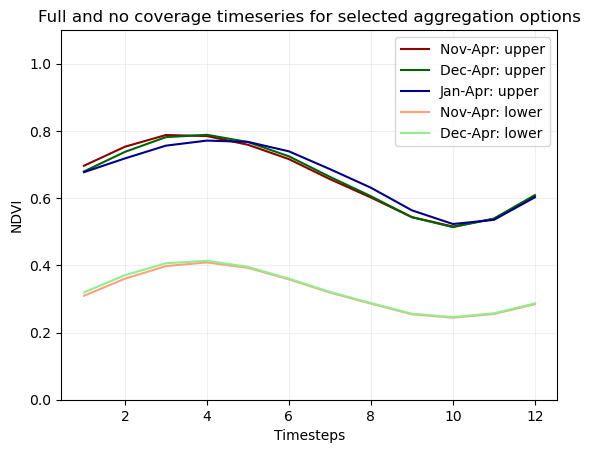

In [53]:
### Plot to compare

fig, ax = plt.subplots()
monthRange_color = ['DarkRed', 'DarkGreen', 'DarkBlue']
for month_index, monthRange in enumerate(full_IA_timeseries_dict.keys()):
    for index, stats in enumerate(['upper', 'mean', 'lower']):
        if stats == 'upper':
            ax.plot(timestep_list, full_IA_timeseries_dict[monthRange][index], label = f'{monthRange}: upper',
                       color = monthRange_color[month_index])    

monthRange_color = ['LightSalmon', 'LightGreen']
for month_index, monthRange in enumerate(no_IA_timeseries_dict.keys()):
    for index, stats in enumerate(['upper', 'mean', 'lower']):
        if stats == 'lower':
            ax.plot(timestep_list, no_IA_timeseries_dict[monthRange][index], label = f'{monthRange}: lower',
                       color = monthRange_color[month_index])    


ax.set_ylim(0,1.1)
ax.set_ylabel('NDVI')
ax.set_xlabel('Timesteps')
ax.set_title('Full and no coverage timeseries for selected aggregation options')
ax.legend(loc = 'upper right')
ax.grid(alpha = 0.2)

Conclusion:

Not much differences within each full and no coverage. 

Hence, we will use Dec to Apr for full coverage as it is consistently between Nov-Apr and Jan-Apr. Moreover, this allows us to avoid residual wet season crops while capturing the maximum number of full coverage pixels to use as references. 

We will use Dec-Apr to avoid residual wet season crops and to match the full coverage month Range since both month Ranges are not visually different. .  


In [54]:
# print out the Dec - Apr upper
print('Full coverage Dec-Apr upper\n')
for x in full_IA_timeseries_dict['Dec-Apr'][0]:
    print(x)

Full coverage Dec-Apr upper

0.6793969195841544
0.7376052143052565
0.7815048769856219
0.788428172837624
0.7669749671699237
0.7243565783259448
0.663371927549938
0.6056893309170686
0.5433077535586419
0.5136307907307707
0.5388372966939617
0.6090687650829616


In [55]:
# print out the Dec - Apr lower 
print('No coverage Dec-Apr lower\n')
for x in no_IA_timeseries_dict['Dec-Apr'][2]:
    print(x)

No coverage Dec-Apr lower

0.31948367050284376
0.3706186825361929
0.406145979136542
0.4136255498570403
0.39543400788091376
0.3604275334009751
0.32083667058067883
0.2879076481457081
0.2559165876578955
0.24591452839753486
0.2571265983200902
0.28678305512215113


In [56]:
### filter for the Dec-Apr
full_coverage_dict_filter = {'Dec-Apr': full_coverage_dict['Dec-Apr']}
no_coverage_dict_filter = {'Dec-Apr': no_coverage_dict['Dec-Apr']}

----------------------------------------------

# __7. Implement full coverage, no coverage and agricultural masks to extract and aggregate reference full coverage timeseries and reference no coverage timeseries__

1. Extract SG filtered NDVI timeseries corresponding to the dry season date matching to the LULC Dynamic World
2. Implement full coverage mask, no coverage mask and agricultural mask regradless of IA to the date matched SG filtered NDVI timeseries to extract reference full coverage timeseries and reference no coverage timeseries 

### 7.1 Extract SG filtered NDVI timeseries that matches the dryseason date of LULC Dynanic world

Extract SG filtered MODIS NDVI timeseries for dates that match LULC Dynamic World dryseason and separate them into their corresponding dryseason instead of one raster stack containing multiple dryseason bands.


- Dry season starts from Novermber and end in March. So it is usually from month 11 to month 4. Going by this strictly, some season have 11 data points and some has 12 data points. This is because some seasons have 1 date of 10-31 while other seasons have 1 date of 11-01. Hence, a physically meaningful way to get 12 data points is to include both 10-31 and 11-01 as dates for November instead of averaging November values into 1 value. 

In [57]:
# read dry season SG filtered MODIS NDVI images 
with rasterio.open('Processed - NDVI timeseries\SG filtered NDVI timeseries -- Dry Season -- 2000-10-31-2019-04-23 .tif') as drySeason_NDVI_img:
    drySeason_NDVI_raster = drySeason_NDVI_img.read()
    drySeason_NDVI_date = drySeason_NDVI_img.descriptions

In [58]:
### Extract only the dry season date that corresponds to LULC Dynamicworld

# initialize variables to store LULC date matched MODIS NDVI bands 
LULC_matched_time_NDVI = []
LULC_matched_time_NDVI_date = []

# define keystring for selecting for and against years and months not matching LULC Dynamic World
LULC_matched_keystring = ['2015', '2016', '2017', '2018', '2019']
not_LULC_matched_keystring = ['2015-01', '2015-02', '2015-03', '2015-04', '2019-11', '2019-12']

# filter only the LULC matched dry season months 
for index, date in enumerate(drySeason_NDVI_date):
    # look for desired months and date
    is_LULC_matched_MD = any(key_string in date for key_string in LULC_matched_keystring)

    # select against undesired years
    is_LULC_matched_year = all(key_string not in date for key_string in not_LULC_matched_keystring)

    # afilter for LULC matched date 
    if is_LULC_matched_MD and is_LULC_matched_year:    
        LULC_matched_time_NDVI.append(drySeason_NDVI_raster[index, :, :])
        LULC_matched_time_NDVI_date.append(date)

# stack the NDVI array
LULC_matched_time_NDVI = np.stack(LULC_matched_time_NDVI, axis = 0)

### separate NDVI array into each dry season that match LULC year 
# inintialize variable to store 
LULC_matched_season_NDVI_dict = {}

# filter for each LULC matched period (every 12 date in a dry season)
for index in range(0, len(LULC_matched_time_NDVI_date), 12):
    
    # obtain time range
    start_year = LULC_matched_time_NDVI_date[index][:4]
    end_year = LULC_matched_time_NDVI_date[index+11][:4]
    LULC_matched_period = f'{start_year}-{end_year}'
    
    # store array
    LULC_matched_season_NDVI_dict[LULC_matched_period] = LULC_matched_time_NDVI[index:index+12, :, :]

# remove dryseason SG filtered NDVI timeseries and date from memory

del drySeason_NDVI_raster, drySeason_NDVI_date, LULC_matched_time_NDVI, LULC_matched_time_NDVI_date

## 7.2 Implement reference full and no coverage time series and agricultural masks to agregate reference fractional irrigated area coverage timeseries.

### Read agricultural mask regardless of IA

In [59]:
### Prepare to read multiple tif file
agricultureMask_folder = 'Processed - Agriculture mask regradless IA'
agricultureMask_filenames = [file for file in os.listdir(agricultureMask_folder) 
                             if file.endswith('.tif') and
                             float(file.split()[5][:-1]) >= 0 and
                             float(file.split()[5][:-1]) <= 100]

In [60]:
### Read agricultural mask regardless of IA

# Intialize dictionary to store multiple agricultural mask
agriculturalMask_dict = {}

# iterate through each tif file name
for agricultureMask_filename in agricultureMask_filenames:
    agricultureMask_filepath = os.path.join(agricultureMask_folder, agricultureMask_filename)

    # Use rasterio to read agricultural mask and the info regarding its creation
    with rasterio.open(agricultureMask_filepath) as agricultureMask_img:
        agriculturalMask_array = agricultureMask_img.read()
        agriculturalMask_info = agricultureMask_img.descriptions[0]
        # agriculturalMask_info = agriculturalMask_info[1:-2]
    # store array in dictionary with the key as creation info
    agriculturalMask_dict[agriculturalMask_info] = agriculturalMask_array


Acquire upper aggregation for full coverage and lower aggregation for no coverage reference timeseries for each agricultural mask regradless of IA

In [61]:
### Use masks to obtain reference full coverage timeseries 

# initialize dictionary for storage for every agriculturalMask and full coverage mask combination
raw_full_IA_timeseries_dict = {} # this will be turned into a nested dictionary (a dict inside a dict)
full_IA_timeseries_dict = {}

## iterate through every agriculturalMask ##
for agriculturalMask_info, agriculturalMask_array in agriculturalMask_dict.items():

    # initialize agriculturalMask_info for matching which agriculture mask the combination came from
    raw_full_IA_timeseries_dict[agriculturalMask_info] = []
    full_IA_timeseries_dict[agriculturalMask_info] = []

## Iterate through full coverage dict to acquire full coverage reference timeseries ##
    for monthRange, full_coverage_array in full_coverage_dict_filter.items():

### Process reference timeseries for every full coverage masks and agricultural mask combination ###

        # Initialize storage variable for each season
        allSeason_reference_timeseries_list = []

        ## iterate through every LULC match season (4 dryseason period in this case) ##
        for dryseason_index, date in enumerate(LULC_matched_season_NDVI_dict.keys()):

            # acquire the NDVI array for the season
            dryseasonal_NDVI_array = LULC_matched_season_NDVI_dict[date]

            # acquire and duplicate full coverage mask to fit agriculturalMask_array
            dryseasonal_full_coverage_array = full_coverage_array[dryseason_index] # obtain array corresponding to the dryseason period
            dryseasonal_full_coverage_array = np.expand_dims(dryseasonal_full_coverage_array, axis = 0)

            # combine agricultural mask and full coverage mask  and get the pixel coordinates
            dryseasonal_full_agriculture_mask = dryseasonal_full_coverage_array * agriculturalMask_array
            row_indices, col_indices = np.where(~np.isnan(dryseasonal_full_agriculture_mask[0]))
            
            # Obtain reference full coverage IA timeseries for a season ##
            dryseasonal_timeseries_pixel_reference = dryseasonal_NDVI_array[:, row_indices, col_indices]

            # store seasonal reference timeseries 
            allSeason_reference_timeseries_list.append(dryseasonal_timeseries_pixel_reference)

        # stack and average once we have all the dryseason timeseries
        allSeason_reference_timeseries_list = np.concatenate(allSeason_reference_timeseries_list, axis = 1)

        # define combination 
        #  combination = f'{agriculturalMask_info}-{monthRange}'
        
        # store raw timesereies count
        raw_full_IA_timeseries_dict[agriculturalMask_info].append(allSeason_reference_timeseries_list)
        
        # store summarized timeseries
        full_IA_timeseries_dict[agriculturalMask_info] = (RSP.raw_reference_timeseries(allSeason_reference_timeseries_list)['upper'])


In [62]:
### Use masks to obtain reference no coverage timeseries 

# initialize dictionary for storage for every agriculturalMask and full coverage mask combination
raw_no_IA_timeseries_dict = {}
no_IA_timeseries_dict = {}

## iterate through every agriculturalMask ##
for agriculturalMask_info, agriculturalMask_array in agriculturalMask_dict.items():

    raw_no_IA_timeseries_dict[agriculturalMask_info] = []
    no_IA_timeseries_dict[agriculturalMask_info] = []

## Iterate through full coverage dict to acquire full coverage reference timeseries ##
    for monthRange, no_coverage_array in no_coverage_dict_filter.items():

### Process reference timeseries for every full coverage masks and agricultural mask combination ###

        # Initialize storage variable for each season
        allSeason_reference_timeseries_list = []

        ## iterate through every LULC match season (4 dryseason period in this case) ##
        for dryseason_index, date in enumerate(LULC_matched_season_NDVI_dict.keys()):

            # acquire the NDVI array for the season
            dryseasonal_NDVI_array = LULC_matched_season_NDVI_dict[date]

            # acquire and duplicate full coverage mask to fit agriculturalMask_array
            dryseasonal_no_coverage_array = no_coverage_array[dryseason_index] # obtain array corresponding to the dryseason period
            dryseasonal_no_coverage_array = np.expand_dims(dryseasonal_no_coverage_array, axis = 0)

            # combine agricultural mask and full coverage mask  and get the pixel coordinates
            dryseasonal_no_agriculture_mask = dryseasonal_no_coverage_array * agriculturalMask_array
            row_indices, col_indices = np.where(~np.isnan(dryseasonal_no_agriculture_mask[0]))
            
            # Obtain reference full coverage IA timeseries for a season ##
            dryseasonal_timeseries_pixel_reference = dryseasonal_NDVI_array[:, row_indices, col_indices]

            # store seasonal reference timeseries 
            allSeason_reference_timeseries_list.append(dryseasonal_timeseries_pixel_reference)

        # stack and average once we have all the dryseason timeseries
        allSeason_reference_timeseries_list = np.concatenate(allSeason_reference_timeseries_list, axis = 1)

        # define combination 
        combination = f'{agriculturalMask_info}-{monthRange}'
        
        # store raw timesereies count 
        raw_no_IA_timeseries_dict[agriculturalMask_info].append(allSeason_reference_timeseries_list)

        # store summarized timeseries
        no_IA_timeseries_dict[agriculturalMask_info] = (RSP.raw_reference_timeseries(allSeason_reference_timeseries_list)['lower'])


In [63]:
### Check if there is any reference no coverage timeseries higher than refereence full cover timeseeries

# initialize total count
total_possible_combition = 0

# initialize count if a combination result in no coverage array higher than full coverage array at any time step
error_count = 0

# itearate through the agriculturalMask_dict
for agriculturalMask_info in agriculturalMask_dict.keys():
    # iterate through reference full timeseries 
    for full_coverage_array in [full_IA_timeseries_dict[agriculturalMask_info]]: # remove list bracket [] if full_IA_timeseries_dict has multiple monthRange
        # iterate through reference no coverage timeseries
        for no_coverage_array in [no_IA_timeseries_dict[agriculturalMask_info]]: # remove list bracket [] if no_IA_timeseries_dict has multiple monthRange

            # increase number of total_possible_combination
            total_possible_combition += 1

            # increase error count
            if np.any(full_coverage_array < no_coverage_array):
                error_count +=1

print('Error count percentage:', round(error_count/total_possible_combition * 100, 2), '%')
print('Total possible combination:', total_possible_combition)
print('Valid combination:', total_possible_combition - error_count)

Error count percentage: 0.0 %
Total possible combination: 41
Valid combination: 41


---------------------------------------------------------

# __8. Use reference full coverage and no coverage to estimate irrigated area__

The stable initial reference full coverage and no coverage timeseries had been computed. However, we do not know wheter to use the stable reference time series as is or dynamically adjust them to fit each dry season's timestep-wise maximum and minimum NDVI. 

To dynamically adjust reference timeseries in each of the 19 dry seasons, the initial full irrigated area coverage timeseries was increased to align with the timestep-wise maximum NDVI from any agricultural pixels within the timestep if the maximum NDVI exceeded the initial reference value. The no coverage timeseries was decreased to align with the timestep-wise minimum NDVI from any agricultural pixels if it was lower than the initial reference value. 

Hence, we need to test both stabler and dynamic reference timeseries.


In [64]:
### function to calculate alpha

def alpha_per_date(NDVIunknown, NDVIfull, NDVIbare):
    alpha = (NDVIunknown - NDVIbare)/(NDVIfull - NDVIbare)
    return alpha

In [65]:
### read and prepare SG filteed NDVI timeseries for dry season

# read SG filter timeseries
with rasterio.open('Processed - NDVI timeseries\SG filtered NDVI timeseries -- Dry Season -- 2000-10-31-2019-04-23 .tif') as dryseason_NDVI_img:
    dryseason_NDVI_raster =  dryseason_NDVI_img.read()
    dryseason_NDVI_date = dryseason_NDVI_img.descriptions
    
    # make a variable for profile for later exports
    dryseason_NDVI_profile = dryseason_NDVI_img.profile

Calculate alpha and fractional coverage alpha based on dynamic adjustment.

In [66]:
### Calculate alpha/fractional coverage for each pixel as full arrays

IA_agriMask_dict= {}

# iterate through each agricultural mask

total_combination_count = 0

for agriculturalMask_info, agriculturalMask_array in agriculturalMask_dict.items():

    
    # iterate through full coverage reference timeseries for the given agricultural mask
    for full_coverage_array in [full_IA_timeseries_dict[agriculturalMask_info]]: # remove list bracket [] if full_IA_timeseries_dict has multiple monthRange
        # iterate through no coverage reference timeseries for the given agricultural mask
        for no_coverage_array in [no_IA_timeseries_dict[agriculturalMask_info]]: # remove list bracket [] if no_IA_timeseries_dict has multiple monthRange
            # check combination validity (full coverage timeseries must be higher than no coverage timeseries for all time step)
            if np.all(full_coverage_array > no_coverage_array):
                
############### Extract fractional coverage, now that we have a candidate agricultural mask, a full coverage timeseries and a no coverage timeseries ###                

                # initialize a variable to store dry seasonally fractional pixel 
                irrigated_alpha_raster_dict = {}

                # define reference full coverage and no coverage timeseries
                ref_full_coverage = full_coverage_array.copy()
                ref_no_coverage = no_coverage_array.copy()

                # extend agricultural mask to match SG filtered dryseason NDVI stack
                extended_agriculture_mask = np.tile(agriculturalMask_array, (dryseason_NDVI_raster.shape[0], 1, 1))
                
                # implement agricultural mask to the NDVI stack thereby excluding non agricultural area 
                dryseason_agriculture_NDVI_raster = dryseason_NDVI_raster * extended_agriculture_mask                

                # iterate through each dry season using dryseason date list (every 12 timestep)
                for index in range(0, len(dryseason_NDVI_date), 12):
                
                    # obtain current season NDVI timeseries
                    current_season_NDVI = dryseason_agriculture_NDVI_raster[index:index+12, :, :].copy()

                    # dynamically update the reference full coverage and reference no coverage for a season
                    updated_full_coverage_array, updated_no_coverage_array = RSP.dynamic_reference_update(current_season_NDVI,full_coverage_array, no_coverage_array)

                    # create empty array to store alpha
                    alpha_array = np.full_like(current_season_NDVI, np.nan)

################### Calculate the fractional coverage for each season ####
                    # iterate through every non nan pixel coordinate
                    for row in np.arange(current_season_NDVI.shape[1]):
                        for col in np.arange(current_season_NDVI.shape[2]):
                            # if pixel coord is not all nan through the 12 timesetep, then we calculate fractional coverage
                            if np.all(~np.isnan(current_season_NDVI[:, row, col])):
                                
                                # calculate alpha which is
                                # NDVIunknown = a(NDVIfull) + (1-a)(NDVIbare) where a is fractional coverage
                                # a = (NDVIunknown - NDVIbare)/(NDVIfull - NDVIbare)
                                for timestep in range(current_season_NDVI.shape[0]):
                                    # get all the variables to calculate alpha
                                    NDVIunknown = current_season_NDVI[timestep, row, col]
                                    NDVIfull = updated_full_coverage_array[timestep]
                                    NDVIbare = updated_no_coverage_array[timestep]
                                    # calculate alpha
                                    alpha = alpha_per_date(NDVIunknown, NDVIfull, NDVIbare)
                                    # append alpha to empty array
                                    alpha_array[timestep, row, col] = alpha

                    # once we have alpha for all months in a single dryseason, we stack the array
                    alpha_array = np.stack(alpha_array, axis = 0)
                    # get current season
                    current_season_date = f'{dryseason_NDVI_date[index]} - {dryseason_NDVI_date[index+11]}'
                    # append to irrigated_area_raster_dict
                    irrigated_alpha_raster_dict[current_season_date] = alpha_array
                    
                    # store data in IA_agriMask_dict[agriculturalMask_info]
                    IA_agriMask_dict[agriculturalMask_info] = irrigated_alpha_raster_dict
                
                # update the total combination count after 1 combination is complete
                total_combination_count += 1
                print(total_combination_count)
                if total_combination_count % 10 == 0:
                    print(f"Current count: {total_combination_count}")
                
print(f'Combination ran: {total_combination_count}')

1
2
3
4
5
6
7
8
9
10
Current count: 10
11
12
13
14
15
16
17
18
19
20
Current count: 20
21
22
23
24
25
26
27
28
29
30
Current count: 30
31
32
33
34
35
36
37
38
39
40
Current count: 40
41
Combination ran: 41


In [67]:
### Make a back up for IA_agriMask_dict
alpha_raster_dict = IA_agriMask_dict.copy()

In [68]:
### Export the alpha rasters to tif file for later ease of access

# for each agriculturalMask/combination, stack the each dryseasonal bands to be 19 dryseasons again for export

# prepare export file
alphaRaster_folder = 'Processed - alpha raster'
os.makedirs(alphaRaster_folder, exist_ok= True)
MODIS_filepath = 'Processed - NDVI timeseries\SG filtered NDVI timeseries -- Dry Season -- 2000-10-31-2019-04-23 .tif'
# iterate through each agricultural mask dict
for agriculturalMask_info, agriculturalMask_dryseason_IA_dict in alpha_raster_dict.items():
    
    # initialize alpha raster stack to hold 19 dry seasons worth of arrays
    alpha_raster_stack = []

    # acquire each dry seasons alpha raster and stack them to form a 19 dry seasons' raster
    for season_array in agriculturalMask_dryseason_IA_dict.values():
        alpha_raster_stack.append(season_array)

    alpha_raster_stack = np.concatenate(alpha_raster_stack, axis = 0)
    
    # export alpha raster stack into tif file
    alphaRaster_name = f'{agriculturalMask_info} - alpha raster (Dec-Apr_seasonal_DynamicRef).tif'
    alphaRaster_outpath = os.path.join(alphaRaster_folder, alphaRaster_name)
    RSP.count_raster_export(MODIS_filepath, alphaRaster_outpath,alpha_raster_stack, dryseason_NDVI_date)

We will need to conduct weighted sum to determine the dry seasonal irrigrated area. We will conduct an equal weighted sum (average the alpha values across all years) and give more weights to Dec, Jan, Feb as those months are when there is vegetation and not harvested yet. For the more, we will ignore the first date of November as there is a likelihood of overlapping with the residual wet season. 

In [69]:
### Conduct weigted sum ###

# initialize variable for storage
irrigated_area_equal_raster_dict = {}


# iterate through each agricultural mask dict
for agriculturalMask_info, agriculturalMask_dryseason_IA_dict in alpha_raster_dict.items():
    
    # initialize dictionary withyin dictionary
    irrigated_area_equal_raster_dict[agriculturalMask_info] = {}

    # acquire each dry seasons alpha raster and stack them to form a 19 dry seasons' raster
    for season_date, season_array in agriculturalMask_dryseason_IA_dict.items():

        ### equal weighted sum
        # equal weighted sum (every timestep is worth around 8.33% or avg the alpha for 12 timestep)
        weighted_sum_equal = np.nanmean(season_array, axis=0)
        # store equal weighted sum in dict
        irrigated_area_equal_raster_dict[agriculturalMask_info][season_date] = weighted_sum_equal

C:\Users\varoc\AppData\Local\Temp\ipykernel_11260\365371098.py:18: RuntimeWarning: Mean of empty slice
  weighted_sum_equal = np.nanmean(season_array, axis=0)


In [70]:
### Calculate the area in km2 and export it to raster together with weighted sum alpha fractional coverage

# calculate total area of a MODIS pixel in km2
MODIS_pixel_area = 250 * 250 / 1000000

### Prepare variables for export and update the profile 
weighted_sum_profile = dryseason_NDVI_profile.copy()
weighted_sum_profile['count'] = 19
weighted_sum_folder = 'Processed - weighted sum area and fractional coverage'
os.makedirs(weighted_sum_folder, exist_ok= True)
## extract both equal and more weights using same dictionary keys
for agriculturalMask_info in irrigated_area_equal_raster_dict.keys():

    # initialize variables to hold alpha stack and area stack for each agriculturalMask
    weighted_sum_equal_alpha = []
    weighted_sum_equal_km2 = []

    # initialize variable to store season_date
    season_date_list = []

    # acquire weighted sum equal and weighted sum more dictionary for the same agricultural Mask
    weighted_sum_equal_dict = irrigated_area_equal_raster_dict[agriculturalMask_info]

    ## extract both equal and more weights using same dictionary keys for the same agricultural mask
    for season_date in weighted_sum_equal_dict.keys():
        # append for alpha
        weighted_sum_equal_alpha.append(weighted_sum_equal_dict[season_date])

        # append for area in km2
        weighted_sum_equal_km2.append(weighted_sum_equal_dict[season_date] *  MODIS_pixel_area)

        season_date_list.append(season_date)

    ## stack alpha and km2 rasters stack to hold 19 dry seasons worth of arrays
    # stack for alpha
    weighted_sum_equal_alpha = np.stack(weighted_sum_equal_alpha, axis = 0)
    # stack for km2 area
    weighted_sum_equal_km2 = np.stack(weighted_sum_equal_km2, axis = 0)
    
    ### Export weighted sum alpha and area ###
    # make an iterable list to loop through and export
    export_list = [['equal', 'alpha', weighted_sum_equal_alpha], 
                   ['equal', 'km2', weighted_sum_equal_km2]]
    
    # iterate through export list
    for export in export_list:
        value_type = export[1]
        export_array = export[2]

        weighted_sum_export_name = f'({agriculturalMask_info})- ({value_type}) DynamicRef.tif'
        weighted_sum_export_path = os.path.join(weighted_sum_folder, weighted_sum_export_name)

        with rasterio.open(weighted_sum_export_path, 'w', **weighted_sum_profile) as dst:
            for index, season_date_value in enumerate(season_date_list):
                dst.write(export_array[index], index+1)
                dst.set_band_description(index+1, season_date_value)

Calculate alpha and fractional coverage based on stable reference timeseries. 

If the unknown timestep-wise NDVI of the unknown pixel exceeds timestep-wise NDVI of the reference full coverage timeseries, it will be considered as full irrigated area. If the unknown timestep-wise NDVI of the unknown pixel is less than timestep-wise NDVI of the reference no coverage timeseries, it will be considered as no irrigated area. 

In [150]:
### Calculate alpha/fractional coverage for each pixel as full arrays

IA_agriMask_dict= {}

# iterate through each agricultural mask

total_combination_count = 0

for agriculturalMask_info, agriculturalMask_array in agriculturalMask_dict.items():

    
    # iterate through full coverage reference timeseries for the given agricultural mask
    for full_coverage_array in [full_IA_timeseries_dict[agriculturalMask_info]]: # remove list bracket [] if full_IA_timeseries_dict has multiple monthRange
        # iterate through no coverage reference timeseries for the given agricultural mask
        for no_coverage_array in [no_IA_timeseries_dict[agriculturalMask_info]]: # remove list bracket [] if no_IA_timeseries_dict has multiple monthRange
            # check combination validity (full coverage timeseries must be higher than no coverage timeseries for all time step)
            if np.all(full_coverage_array > no_coverage_array):
                
############### Extract fractional coverage, now that we have a candidate agricultural mask, a full coverage timeseries and a no coverage timeseries ###                

                # initialize a variable to store dry seasonally fractional pixel 
                irrigated_alpha_raster_dict = {}

                # define reference full coverage and no coverage timeseries
                ref_full_coverage = full_coverage_array.copy()
                ref_no_coverage = no_coverage_array.copy()

                # extend agricultural mask to match SG filtered dryseason NDVI stack
                extended_agriculture_mask = np.tile(agriculturalMask_array, (dryseason_NDVI_raster.shape[0], 1, 1))
                
                # implement agricultural mask to the NDVI stack thereby excluding non agricultural area 
                dryseason_agriculture_NDVI_raster = dryseason_NDVI_raster * extended_agriculture_mask                

                # iterate through each dry season using dryseason date list (every 12 timestep)
                for index in range(0, len(dryseason_NDVI_date), 12):
                
                    # obtain current season NDVI timeseries
                    current_season_NDVI = dryseason_agriculture_NDVI_raster[index:index+12, :, :].copy()

                    # create empty array to store alpha
                    alpha_array = np.full_like(current_season_NDVI, np.nan)

################### Calculate the fractional coverage for each season ####
                    # iterate through every non nan pixel coordinate
                    for row in np.arange(current_season_NDVI.shape[1]):
                        for col in np.arange(current_season_NDVI.shape[2]):
                            # if pixel coord is not all nan through the 12 timesetep, then we calculate fractional coverage
                            if np.all(~np.isnan(current_season_NDVI[:, row, col])):
                                
                                # calculate alpha which is
                                # NDVIunknown = a(NDVIfull) + (1-a)(NDVIbare) where a is fractional coverage
                                # a = (NDVIunknown - NDVIbare)/(NDVIfull - NDVIbare)
                                for timestep in range(current_season_NDVI.shape[0]):
                                    # get all the variables to calculate alpha
                                    NDVIunknown = current_season_NDVI[timestep, row, col]
                                    NDVIfull = full_coverage_array[timestep]
                                    NDVIbare = no_coverage_array[timestep]
                                    # calculate alpha
                                    alpha = alpha_per_date(NDVIunknown, NDVIfull, NDVIbare)
                                    # append alpha to empty array
                                    alpha_array[timestep, row, col] = alpha

                    # once we have alpha for all months in a single dryseason, we stack the array
                    alpha_array = np.stack(alpha_array, axis = 0)

                    # correct alpha of more than 1 and less than p
                    alpha_array[alpha_array > 1] = 1
                    alpha_array[alpha_array < 0] = 0

                    # get current season
                    current_season_date = f'{dryseason_NDVI_date[index]} - {dryseason_NDVI_date[index+11]}'
                    # append to irrigated_area_raster_dict
                    irrigated_alpha_raster_dict[current_season_date] = alpha_array
                    
                    # store data in IA_agriMask_dict[agriculturalMask_info]
                    IA_agriMask_dict[agriculturalMask_info] = irrigated_alpha_raster_dict
                
                # update the total combination count after 1 combination is complete
                total_combination_count += 1
                print(total_combination_count)
                if total_combination_count % 10 == 0:
                    print(f"Current count: {total_combination_count}")
                
print(f'Combination ran: {total_combination_count}')

1
2
3
4
5
6
7
8
9
10
Current count: 10
11
12
13
14
15
16
17
18
19
20
Current count: 20
21
22
23
24
25
26
27
28
29
30
Current count: 30
31
32
33
34
35
36
37
38
39
40
Current count: 40
41
Combination ran: 41


In [151]:
### Make a back up for IA_agriMask_dict
alpha_raster_dict = IA_agriMask_dict.copy()

In [152]:
### Export the alpha rasters to tif file for later ease of access

# for each agriculturalMask/combination, stack the each dryseasonal bands to be 19 dryseasons again for export

# prepare export file
alphaRaster_folder = 'Processed - alpha raster'
os.makedirs(alphaRaster_folder, exist_ok= True)
MODIS_filepath = 'Processed - NDVI timeseries\SG filtered NDVI timeseries -- Dry Season -- 2000-10-31-2019-04-23 .tif'
# iterate through each agricultural mask dict
for agriculturalMask_info, agriculturalMask_dryseason_IA_dict in alpha_raster_dict.items():
    
    # initialize alpha raster stack to hold 19 dry seasons worth of arrays
    alpha_raster_stack = []

    # acquire each dry seasons alpha raster and stack them to form a 19 dry seasons' raster
    for season_array in agriculturalMask_dryseason_IA_dict.values():
        alpha_raster_stack.append(season_array)

    alpha_raster_stack = np.concatenate(alpha_raster_stack, axis = 0)
    
    # export alpha raster stack into tif filed
    alphaRaster_name = f'{agriculturalMask_info} - alpha raster (Dec-Apr_seasonal_StableRef).tif'
    alphaRaster_outpath = os.path.join(alphaRaster_folder, alphaRaster_name)
    RSP.count_raster_export(MODIS_filepath, alphaRaster_outpath,alpha_raster_stack, dryseason_NDVI_date)

In [11]:
MODIS_pixel_area = 250 * 250 / 1000000


In [162]:
### Conduct weigted sum ###

# initialize variable for storage
irrigated_area_equal_raster_dict = {}

# iterate through each agricultural mask dict
for agriculturalMask_info, agriculturalMask_dryseason_IA_dict in alpha_raster_dict.items():
    
    # initialize dictionary withyin dictionary
    irrigated_area_equal_raster_dict[agriculturalMask_info] = {}

    # acquire each dry seasons alpha raster and stack them to form a 19 dry seasons' raster
    for season_date, season_array in agriculturalMask_dryseason_IA_dict.items():

        ### equal weighted sum
        # equal weighted sum (every timestep is worth around 8.33% or avg the alpha for 12 timestep)
        weighted_sum_equal = np.nanmean(season_array, axis=0)
        # store equal weighted sum in dict
        irrigated_area_equal_raster_dict[agriculturalMask_info][season_date] = weighted_sum_equal

C:\Users\varoc\AppData\Local\Temp\ipykernel_22016\1801212667.py:17: RuntimeWarning: Mean of empty slice
  weighted_sum_equal = np.nanmean(season_array, axis=0)


In [163]:
### Calculate the area in km2 and export it to raster together with weighted sum alpha fractional coverage

# calculate total area of a MODIS pixel in km2
MODIS_pixel_area = 250 * 250 / 1000000

### Prepare variables for export and update the profile 
weighted_sum_profile = dryseason_NDVI_profile.copy()
weighted_sum_profile['count'] = 19
weighted_sum_folder = 'Processed - weighted sum area and fractional coverage'
os.makedirs(weighted_sum_folder, exist_ok= True)
## extract both equal and more weights using same dictionary keys
for agriculturalMask_info in irrigated_area_equal_raster_dict.keys():

    # initialize variables to hold alpha stack and area stack for each agriculturalMask
    stable_weighted_sum_equal_alpha = []
    stable_weighted_sum_equal_km2 = []

    # initialize variable to store season_date
    season_date_list = []

    # acquire weighted sum equal and weighted sum more dictionary for the same agricultural Mask
    weighted_sum_equal_dict = irrigated_area_equal_raster_dict[agriculturalMask_info]

    ## extract both equal and more weights using same dictionary keys for the same agricultural mask
    for season_date in weighted_sum_equal_dict.keys():
        # append for alpha
        stable_weighted_sum_equal_alpha.append(weighted_sum_equal_dict[season_date])

        # append for area in km2
        stable_weighted_sum_equal_km2.append(weighted_sum_equal_dict[season_date] *  MODIS_pixel_area)

        season_date_list.append(season_date)

    ## stack alpha and km2 rasters stack to hold 19 dry seasons worth of arrays
    # stack for alpha
    stable_weighted_sum_equal_alpha = np.stack(stable_weighted_sum_equal_alpha, axis = 0)
   
    # stack for km2 area
    stable_weighted_sum_equal_km2 = np.stack(stable_weighted_sum_equal_km2, axis = 0)
    
    
    ### Export weighted sum alpha and area ###
    # make an iterable list to loop through and export
    export_list = [['equal', 'alpha', stable_weighted_sum_equal_alpha], 
                   ['equal', 'km2', stable_weighted_sum_equal_km2]]
    
    # iterate through export list
    for export in export_list:
        value_type = export[1]
        export_array = export[2]

        weighted_sum_export_name = f'({agriculturalMask_info})- ({value_type}) StableRef.tif'
        weighted_sum_export_path = os.path.join(weighted_sum_folder, weighted_sum_export_name)

        with rasterio.open(weighted_sum_export_path, 'w', **weighted_sum_profile) as dst:
            for index, season_date_value in enumerate(season_date_list):
                dst.write(export_array[index], index+1)
                dst.set_band_description(index+1, season_date_value)

----------------------------------------------

# __9. Compare with Erban and Gorelick (2016) method__

## 9.1 Replicate Erban and Gorelick (2016)'s method to Prey Veng and Svay Rieng's late 2000 - early 2019 dry seasons.

In [2]:
# Read the max ndvi composite
max_ndvi_folder = 'MODIS Max NDVI Composite Jan-Mar 2001-2019'
max_ndvi_file_list = [file for file in os.listdir(max_ndvi_folder) 
                      if file.endswith('.tif') and '2Pro' in file and
                      '2000' not in file and '2020' not in file]

# initialize variable for storage
max_image_date_list = []
max_image_NDVI_list = []


for filename in max_ndvi_file_list:
    max_ndvi_path = os.path.join(max_ndvi_folder, filename)
    date = filename[-26:-4]
    with rasterio.open(max_ndvi_path) as img:
        max_DN_array = img.read(1).astype('float64')
        
        # process nodata value (nodata and -3000)
        max_DN_array[max_DN_array == -3000] = np.nan
        max_DN_array[max_DN_array == img.nodata] = np.nan

        # scale DN to index value
        max_NDVI_array = max_DN_array * 0.0001
        
        # store date and NDVI array
        max_image_date_list.append(date)
        max_image_NDVI_list.append(max_NDVI_array)

# stack NDVI array
max_stacked_NDVI_MODIS = np.stack(max_image_NDVI_list, axis = 0) # shape now is (date, row, column)

# select against white space
# iterate through row
for row in np.arange(max_stacked_NDVI_MODIS.shape[1]):
    # iterate through column
    for col in np.arange(max_stacked_NDVI_MODIS.shape[2]):
        # for white space, replace with np.nan
        if np.nansum(max_stacked_NDVI_MODIS[:, row, col]) == 0:
            max_stacked_NDVI_MODIS[:, row, col] = np.full_like(max_stacked_NDVI_MODIS[:, row, col], np.nan)


In [3]:
MODIS_pixel_area = 250 * 250 / 1000000

In [4]:
### Perform thresholding of 0.55
threshold_max_stacked_NDVI_MODIS = max_stacked_NDVI_MODIS.copy()
threshold_max_stacked_NDVI_MODIS[threshold_max_stacked_NDVI_MODIS < 0.55] = np.nan
threshold_max_stacked_NDVI_MODIS[threshold_max_stacked_NDVI_MODIS >= 0.55] = 1

### obtain area in km
threshold_max_stacked_NDVI_MODIS_area =  threshold_max_stacked_NDVI_MODIS.copy()
threshold_max_stacked_NDVI_MODIS_area = threshold_max_stacked_NDVI_MODIS_area * MODIS_pixel_area

In [5]:
### export thresholded stack to GeoTiff file

# generate dry season for descriptions
season_list = []

with rasterio.open('Processed - weighted sum area and fractional coverage\(35.01% -- 39-crops-0.3_mean--39-trees-0.2_upper)- (alpha) DynamicRef.tif') as img:
    season_date_list2 = list(img.descriptions)
    for date in season_date_list2:
        start_year = date.split()[0][:4]
        end_year = date.split()[2][:4]
        season_list.append(f'{start_year}-{end_year}')

# export the max stack array
out_folder = 'Processed - Erban and Gorelick (2016) threshold result'
os.makedirs(out_folder, exist_ok= True)
outdir_filename = os.path.join(out_folder, 'EB(2016) thresholded array.tif')
RSP.count_raster_export(max_ndvi_path, outdir_filename, threshold_max_stacked_NDVI_MODIS, season_list)

## 9.2 Acquire fractional coverage from stable and dynamic reference timeseries and compare their areas together with the Erban and Gorelick (2016) replication. 

In [6]:
# Prepare filename list to read area

weighted_sum_folder = 'Processed - weighted sum area and fractional coverage'


dynamic_filenames = [file for file in os.listdir(weighted_sum_folder) 
                                if file.endswith('.tif') and 
                                'km2' in file and 'dynamic' in file.lower()]
stable_filenames = [file for file in os.listdir(weighted_sum_folder) 
                                if file.endswith('.tif') and 
                                'km2' in file and 'stable' in file.lower()]

date_list = ['2000-10-31 - 2001-04-23', '2001-11-01 - 2002-04-23', '2002-11-01 - 2003-04-23', 
             '2003-11-01 - 2004-04-22', '2004-10-31 - 2005-04-23', '2005-11-01 - 2006-04-23', 
             '2006-11-01 - 2007-04-23', '2007-11-01 - 2008-04-22','2008-10-31 - 2009-04-23',
             '2009-11-01 - 2010-04-23', '2010-11-01 - 2011-04-23', '2011-11-01 - 2012-04-22', 
             '2012-10-31 - 2013-04-23', '2013-11-01 - 2014-04-23', '2014-11-01 - 2015-04-23', 
             '2015-11-01 - 2016-04-22', '2016-10-31 - 2017-04-23', '2017-11-01 - 2018-04-23', 
             '2018-11-01 - 2019-04-23']

In [7]:
def area_stat(weighted_dict):
    weighted_sum_mean_list = []
    weighted_sum_std_list = []
    for date in weighted_dict.keys():
        weighted_sum_mean_list.append(np.mean(weighted_dict[date]))
        weighted_sum_std_list.append(np.std(weighted_dict[date]))

    return weighted_sum_mean_list, weighted_sum_std_list

In [8]:
### Acquire area in km2 for dynamically adjusted reference timeseries

dynamic_areas = {date: [] for date in date_list}

for filename in dynamic_filenames:
    path = os.path.join(weighted_sum_folder, filename)
    with rasterio.open(path) as img:
        area_array = img.read()
        area_date = img.descriptions
    for index, date in enumerate(area_date):
        dynamic_areas[date].append(np.nansum(area_array[index]))

In [9]:
### Acquire area in km2 for stable reference timeseries

stable_areas = {date: [] for date in date_list}

for filename in stable_filenames:
    path = os.path.join(weighted_sum_folder, filename)
    with rasterio.open(path) as img:
        area_array = img.read()
        area_date = img.descriptions
    for index, date in enumerate(area_date):
        stable_areas[date].append(np.nansum(area_array[index]))

Plot line plots for comparison and display IA dynamic numbers

In [10]:
# calculate mean irrigated areas and std from the 41 combinations for each dry season

Erban_Gorelick_area = [np.nansum(threshold_max_stacked_NDVI_MODIS_area[index]) for index in np.arange(threshold_max_stacked_NDVI_MODIS_area.shape[0])]

# Dynamic reference area
dynamic_mean_list, dynamic_std_list = area_stat(dynamic_areas)

# Stable reference area
stable_mean_list, stable_std_list = area_stat(stable_areas)

In [11]:
### display Erban and Gorelick (2016)'s total area and statistics
for date, area in zip(date_list, Erban_Gorelick_area):
    print(f'{date}: {area}')

# maximum
max_area = max(Erban_Gorelick_area)
max_area_index = Erban_Gorelick_area.index(max_area)
max_area_date = date_list[Erban_Gorelick_area.index(max_area)]

# median
median_area = np.median(Erban_Gorelick_area)
median_area_index = Erban_Gorelick_area.index(median_area)
median_area_date = date_list[Erban_Gorelick_area.index(median_area)]

# minimum
min_area = min(Erban_Gorelick_area)
min_area_index = Erban_Gorelick_area.index(min_area)
min_area_date = date_list[Erban_Gorelick_area.index(min_area)]

print('\n\n')
print(f'maximum:{max_area_date} --- {max_area}: {max_area_index}')
print(f'median:{median_area_date} --- {median_area}: {median_area_index}')
print(f'minimum:{min_area_date} --- {min_area}: {min_area_index}')

2000-10-31 - 2001-04-23: 2312.0625
2001-11-01 - 2002-04-23: 1724.1875
2002-11-01 - 2003-04-23: 2708.5625
2003-11-01 - 2004-04-22: 1832.625
2004-10-31 - 2005-04-23: 1804.375
2005-11-01 - 2006-04-23: 2456.375
2006-11-01 - 2007-04-23: 1990.125
2007-11-01 - 2008-04-22: 2069.25
2008-10-31 - 2009-04-23: 2215.6875
2009-11-01 - 2010-04-23: 1999.25
2010-11-01 - 2011-04-23: 2338.4375
2011-11-01 - 2012-04-22: 2916.125
2012-10-31 - 2013-04-23: 2477.6875
2013-11-01 - 2014-04-23: 2284.4375
2014-11-01 - 2015-04-23: 1791.25
2015-11-01 - 2016-04-22: 2882.75
2016-10-31 - 2017-04-23: 4255.3125
2017-11-01 - 2018-04-23: 4082.3125
2018-11-01 - 2019-04-23: 4764.25



maximum:2018-11-01 - 2019-04-23 --- 4764.25: 18
median:2000-10-31 - 2001-04-23 --- 2312.0625: 0
minimum:2001-11-01 - 2002-04-23 --- 1724.1875: 1


In [12]:
### display fractional coverage's mean total area and statistics
for date, area in zip(date_list, dynamic_mean_list):
    print(f'{date}: {area}')


2000-10-31 - 2001-04-23: 1855.9371431810591
2001-11-01 - 2002-04-23: 1685.2381345486642
2002-11-01 - 2003-04-23: 1855.5933806155813
2003-11-01 - 2004-04-22: 1709.5110821846934
2004-10-31 - 2005-04-23: 1592.1081045542437
2005-11-01 - 2006-04-23: 1901.6290834811484
2006-11-01 - 2007-04-23: 1837.3559737486396
2007-11-01 - 2008-04-22: 1791.6933609056787
2008-10-31 - 2009-04-23: 1920.000804972823
2009-11-01 - 2010-04-23: 1710.0207223114148
2010-11-01 - 2011-04-23: 1715.824417365815
2011-11-01 - 2012-04-22: 1884.748347130893
2012-10-31 - 2013-04-23: 1793.968562462547
2013-11-01 - 2014-04-23: 1810.0814389555708
2014-11-01 - 2015-04-23: 1743.9731642734773
2015-11-01 - 2016-04-22: 1669.2537091289787
2016-10-31 - 2017-04-23: 2071.2573658150395
2017-11-01 - 2018-04-23: 1981.452162540572
2018-11-01 - 2019-04-23: 1955.9000106329975


C:\Users\varoc\AppData\Local\Temp\ipykernel_12140\4127281009.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(season_list, rotation=90)


''

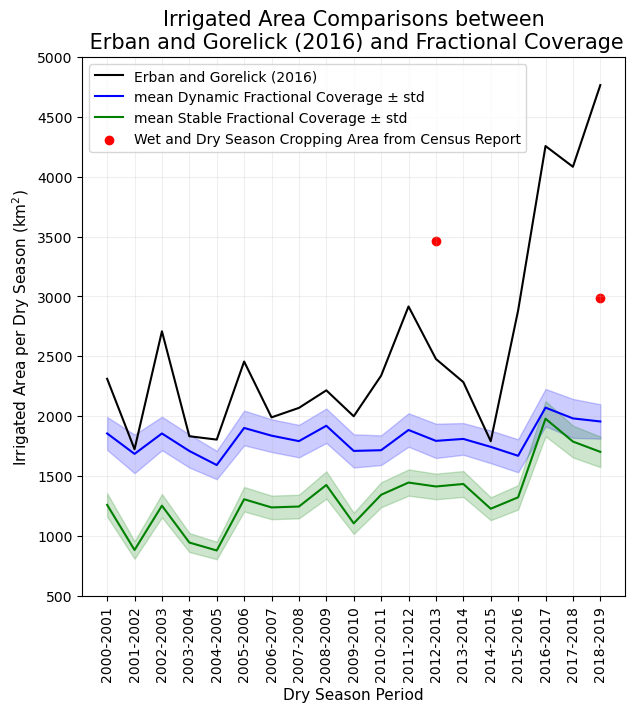

In [13]:
# plot IA dynamics
plus_minus = "\u00B1"

fig,ax = plt.subplots(figsize = (7,7))
# Erban and Gorelick (2016)
ax.plot(season_list, Erban_Gorelick_area, label = 'Erban and Gorelick (2016)', color = 'k')

# dynamic
ax.plot(season_list,dynamic_mean_list, label = f'mean Dynamic Fractional Coverage {plus_minus} std', color = 'blue')
dynamic_upper = np.array(dynamic_mean_list) + np.array(dynamic_std_list)
dynamic_lower = np.array(dynamic_mean_list) - np.array(dynamic_std_list)
ax.fill_between(range(len(dynamic_mean_list)), dynamic_upper, dynamic_lower, color='blue', alpha=0.2)


# stable
ax.plot(season_list,stable_mean_list, label = f'mean Stable Fractional Coverage {plus_minus} std', color = 'green')
stable_upper = np.array(stable_mean_list) + np.array(stable_std_list)
stable_lower = np.array(stable_mean_list) - np.array(stable_std_list)
ax.fill_between(range(len(stable_mean_list)), stable_upper, stable_lower, color='green', alpha=0.2)

# plot census data
ax.scatter('2012-2013', 3463.5776, color = 'red', label = 'Wet and Dry Season Cropping Area from Census Report')
ax.scatter('2018-2019', 2987.04, color = 'red')

# aesthetics
ax.set_ylabel('Irrigated Area per Dry Season (km$^2$)', fontsize = 11)
ax.set_xlabel('Dry Season Period', fontsize = 11)
ax.set_title('Irrigated Area Comparisons between\n Erban and Gorelick (2016) and Fractional Coverage', fontsize = 15)
ax.set_xticklabels(season_list, rotation=90)
ax.legend()
ax.grid(alpha = 0.2)
ax.set_ylim(500, 5000)
;

Conclusion:

The dynamic reference is theoretically more correct since it accounts for the variations between each seasons. Hence, we will use the dynamic reference

C:\Users\varoc\AppData\Local\Temp\ipykernel_12140\2704349782.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(season_list, rotation=90)


''

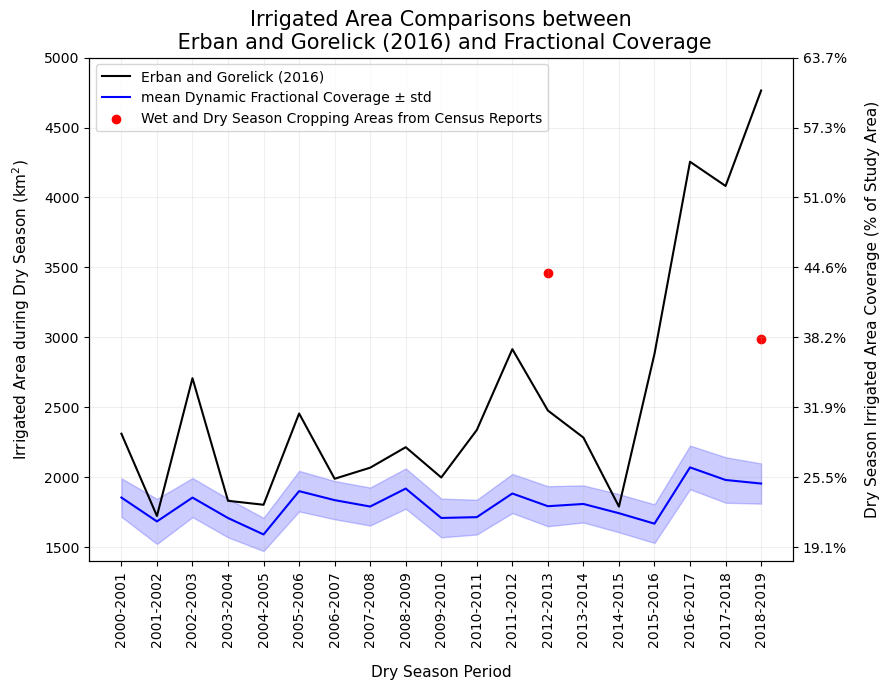

In [14]:
### plot Erban and Gorelick (2016) and dynamic reference

Pro2_total_area = 7849

fig,ax = plt.subplots(figsize = (9,7))
# Erban and Gorelick (2016)
ax.plot(season_list, Erban_Gorelick_area, label = 'Erban and Gorelick (2016)', color = 'k')

# dynamic
ax.plot(season_list,dynamic_mean_list, label = f'mean Dynamic Fractional Coverage {plus_minus} std', color = 'blue')
dynamic_upper = np.array(dynamic_mean_list) + np.array(dynamic_std_list)
dynamic_lower = np.array(dynamic_mean_list) - np.array(dynamic_std_list)
ax.fill_between(range(len(dynamic_mean_list)), dynamic_upper, dynamic_lower, color='blue', alpha=0.2)

# plot census data
ax.scatter('2012-2013', 3463.5776, color = 'red', label = 'Wet and Dry Season Cropping Areas from Census Reports')
ax.scatter('2018-2019', 2987.04, color = 'red')


# aesthetics
ax.set_ylabel('Irrigated Area during Dry Season (km$^2$)', fontsize = 11, labelpad = 9)
ax.set_xlabel('Dry Season Period', fontsize = 11, labelpad = 13)
ax.set_title('Irrigated Area Comparisons between\n Erban and Gorelick (2016) and Fractional Coverage', fontsize = 15)
ax.set_xticklabels(season_list, rotation=90)
ax.legend()
ax.grid(alpha = 0.2)
ax.set_ylim(1400, 5000)


# create secondary axis for percentage
ax2 = ax.twinx()
Erban_Gorelick_area_percent = (np.array(Erban_Gorelick_area) / Pro2_total_area) * 100

sec_tick = np.linspace(1500, 5000, 8)/Pro2_total_area * 100


# Set the labels of the secondary axis as percentage values
ax2.set_yticks(sec_tick)
ax2.set_yticklabels([f'{p:.1f}%' for p in sec_tick])
ax2.set_ylim(1400/Pro2_total_area*100, 5000/Pro2_total_area*100)
ax2.set_ylabel("Dry Season Irrigated Area Coverage (% of Study Area)", fontsize = 11, labelpad = 13)


plt.tight_layout()
;

In [15]:
### prepare to plot Erban and gorelick with mean dynamic fractional coverage and min, median and max agri percent

# read the array and turn them into 
min_percent = 35.01
median_percent = 41.75
max_percent = 44.83

filenames = [file for file in os.listdir(weighted_sum_folder) 
             if file.endswith('.tif') and 'km2' in file and 'dynamic' in file.lower() and
             (str(max_percent) in file or str(median_percent) in file or str(min_percent) in file)]

stats_area_dict = {}

# convert area into total area in km2 per dry season
for file in filenames:
    path = os.path.join(weighted_sum_folder, file)

    with rasterio.open(path) as img:
        raster = img.read()
    
    stats_area_dict[float(file.split()[0][1:-1])] = [np.nansum(raster[index]) for index in np.arange(raster.shape[0])]

    

C:\Users\varoc\AppData\Local\Temp\ipykernel_12140\4221120195.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(season_list, rotation=90)


''

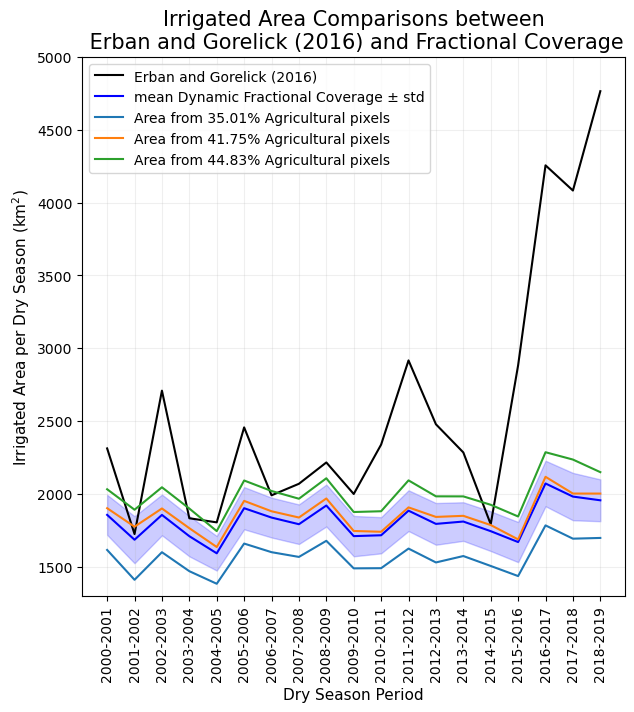

In [16]:
### plot Erban and gorelick with mean dynamic fractional coverage and min, median and max agri percent

### plot Erban and Gorelick (2016) and dynamic reference

fig,ax = plt.subplots(figsize = (7,7))
# Erban and Gorelick (2016)
ax.plot(season_list, Erban_Gorelick_area, label = 'Erban and Gorelick (2016)', color = 'k')

# dynamic mean and std
ax.plot(season_list,dynamic_mean_list, label = f'mean Dynamic Fractional Coverage {plus_minus} std', color = 'blue')
dynamic_upper = np.array(dynamic_mean_list) + np.array(dynamic_std_list)
dynamic_lower = np.array(dynamic_mean_list) - np.array(dynamic_std_list)
ax.fill_between(range(len(dynamic_mean_list)), dynamic_upper, dynamic_lower, color='blue', alpha=0.2)

# minimum 
ax.plot(season_list, stats_area_dict[min_percent], label = f'Area from {min_percent}% Agricultural pixels')

# median
ax.plot(season_list, stats_area_dict[median_percent], label = f'Area from {median_percent}% Agricultural pixels')

# max
ax.plot(season_list, stats_area_dict[max_percent], label = f'Area from {max_percent}% Agricultural pixels')

# aesthetics
ax.set_ylabel('Irrigated Area per Dry Season (km$^2$)', fontsize = 11)
ax.set_xlabel('Dry Season Period', fontsize = 11)
ax.set_title('Irrigated Area Comparisons between\n Erban and Gorelick (2016) and Fractional Coverage', fontsize = 15)
ax.set_xticklabels(season_list, rotation=90)
ax.legend()
ax.grid(alpha = 0.2)
ax.set_ylim(1300, 5000)
;


In [17]:
#### calclaue the percentage variation of Erband and Gorelick and mean fractional coverage

def percent_variation(area_list):
    percentage_change = [abs((area - area_list[i - 1]) / area_list[i - 1]) * 100 for i, area in enumerate(area_list) if i > 0]
    return percentage_change


print("Erban & Gorelick (2016) mean percent variation", np.mean(percent_variation(Erban_Gorelick_area)))
print("Erban & Gorelick (2016) before 2015-2016 mean percent variation", np.mean(percent_variation(Erban_Gorelick_area[:15])))
print("Fractional coverage mean mean percent variation", np.mean(percent_variation(dynamic_mean_list)))


Erban & Gorelick (2016) mean percent variation 22.652661662379728
Erban & Gorelick (2016) before 2015-2016 mean percent variation 19.8878328307161
Fractional coverage mean mean percent variation 7.277450325590739


## 9.3 Compute the average fractional coverage through time and through agricultural area percentage

This is to see the effect of increasing the agricultural area on average fractional coverage area 

In [18]:
### set up for reading 
fractional_area_folder = 'Processed - weighted sum area and fractional coverage'
fraction_filenames = [file for file in os.listdir(fractional_area_folder) 
                 if file.endswith('.tif') and 
                 'alpha' in file and
                 'dynamic' in file.lower()]

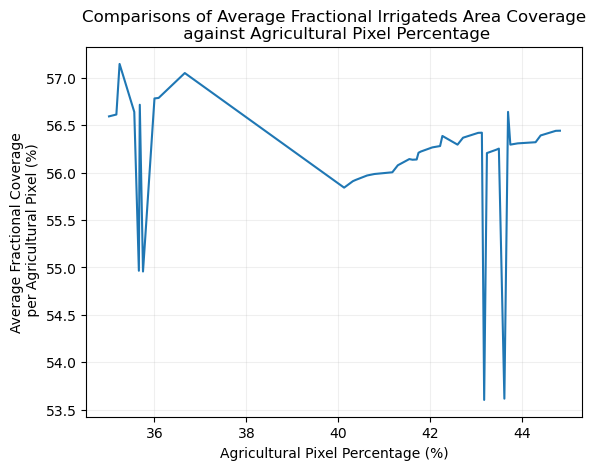

In [19]:
### acquire average fractional coverage in a MODIS pixel by agricultural area percentage

# read arrays into each agricultural alpha
agriPercent_fraction_dict = {}

for filename in fraction_filenames: 
    path = os.path.join(fractional_area_folder, filename)
    
    # get percentage of the agricultural area regardless of IA
    agri_percentage = filename[1:6]
    if '%' in agri_percentage:
        agri_percentage = agri_percentage.replace('%', '0')
    agri_percentage = float(agri_percentage)

    # read, convert alpha into percentage and store
    with rasterio.open(path) as img:
        raster = img.read()
        raster_date = img.descriptions
    agriPercent_fraction_dict[agri_percentage] = raster*100 # x 100 to convert fraction into percent


# get average fractional coverage percentage by agricultural area regardless of IA
agriPercent_avgFrac_dict = {agriPercent: np.nanmean(array_stack) for agriPercent, array_stack in agriPercent_fraction_dict.items()}

### plot the average fractional coverage percentage by agricultural area regardless of IA
plt.plot(figsize = (7,7))
plt.plot(agriPercent_avgFrac_dict.keys(), agriPercent_avgFrac_dict.values())
plt.xlabel('Agricultural Pixel Percentage (%)', fontsize = 10)
plt.ylabel('Average Fractional Coverage\n per Agricultural Pixel (%)', fontsize = 10)
plt.title('Comparisons of Average Fractional Irrigateds Area Coverage\n against Agricultural Pixel Percentage')
plt.grid(alpha = 0.2)

In [20]:
### Display max, mean, median and min

# Find the minimum, median, and maximum values and their corresponding keys
min_value = min(agriPercent_avgFrac_dict.values())
median_value = np.median(list(agriPercent_avgFrac_dict.values()))
max_value = max(agriPercent_avgFrac_dict.values())

min_key = [key for key, value in agriPercent_avgFrac_dict.items() if value == min_value]
median_key = [key for key, value in agriPercent_avgFrac_dict.items() if value == median_value]
max_key = [key for key, value in agriPercent_avgFrac_dict.items() if value == max_value]

# Calculate the mean value
mean_value = np.mean(list(agriPercent_avgFrac_dict.values()))

# Display the results
print("Minimum Value Key(s):", min_key)
print("Minimum Value:", min_value)
print()
print("Median Value Key(s):", median_key)
print("Median Value:", median_value)
print()
print("Mean Value:", mean_value)
print()
print("Maximum Value Key(s):", max_key)
print("Maximum Value:", max_value)


Minimum Value Key(s): [43.18]
Minimum Value: 53.60164599160546

Median Value Key(s): [42.22]
Median Value: 56.280793959391126

Mean Value: 56.146905784074214

Maximum Value Key(s): [35.24]
Maximum Value: 57.1474326087818


''

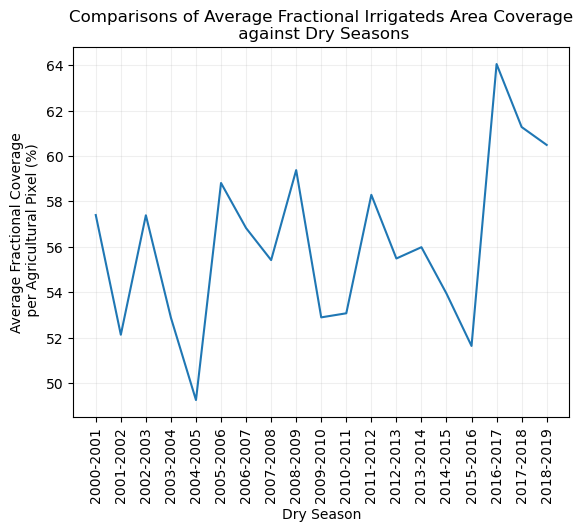

In [21]:
### acquire average fractional coverage in a MODIS pixel by dry season

# separate arrays into dry season
seasonal_fraction_dict = {date:[] for date in raster_date}

for array in agriPercent_fraction_dict.values():
    for index, date in enumerate(raster_date):
        seasonal_fraction_dict[date].append(array[index])

for date, array_list in seasonal_fraction_dict.items():
    array_list = np.stack(array_list, axis = 0)
    seasonal_fraction_dict[date] = array_list


# get average fractional coverage percentage by dry season
seasonal_avgFrac_dict = {season: np.nanmean(array_stack) for season, array_stack in seasonal_fraction_dict.items()}

### plot
plt.plot(figsize = (7,7))
plt.plot(season_list, seasonal_avgFrac_dict.values())
plt.xlabel('Dry Season', fontsize = 10)
plt.ylabel('Average Fractional Coverage\n per Agricultural Pixel (%)', fontsize = 10)
plt.xticks(rotation = 90)
# plt.ylim(0, 100)
plt.title('Comparisons of Average Fractional Irrigateds Area Coverage\n against Dry Seasons')
plt.grid(alpha = 0.2)
;

In [22]:
### Display max, mean, median and min

# Find the minimum, median, and maximum values and their corresponding keys
min_value = min(seasonal_avgFrac_dict.values())
median_value = np.median(list(seasonal_avgFrac_dict.values()))
max_value = max(seasonal_avgFrac_dict.values())

min_key = [key for key, value in seasonal_avgFrac_dict.items() if value == min_value]
median_key = [key for key, value in seasonal_avgFrac_dict.items() if value == median_value]
max_key = [key for key, value in seasonal_avgFrac_dict.items() if value == max_value]

# Calculate the mean value
mean_value = np.mean(list(seasonal_avgFrac_dict.values()))

# Display the results
print("Minimum Value Key(s):", min_key)
print("Minimum Value:", min_value)
print()
print("Median Value Key(s):", median_key)
print("Median Value:", median_value)
print()
print("Mean Value:", mean_value)
print()
print("Maximum Value Key(s):", max_key)
print("Maximum Value:", max_value)


Minimum Value Key(s): ['2004-10-31 - 2005-04-23']
Minimum Value: 49.241981337471536

Median Value Key(s): ['2013-11-01 - 2014-04-23']
Median Value: 55.98363338606885

Mean Value: 56.13664891331289

Maximum Value Key(s): ['2016-10-31 - 2017-04-23']
Maximum Value: 64.06148945590618


C:\Users\varoc\AppData\Local\Temp\ipykernel_12140\4158745626.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(season_list, rotation=90)


''

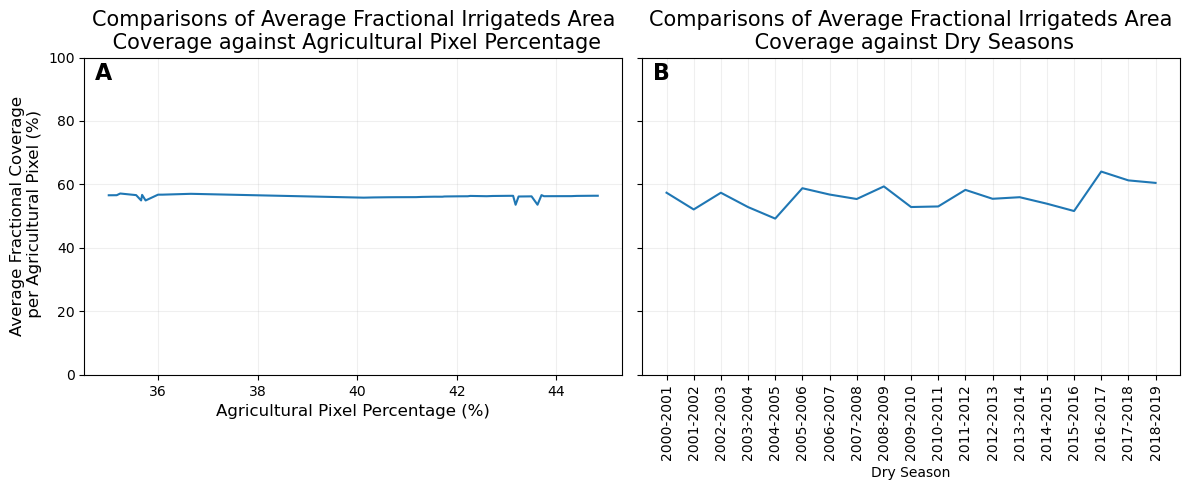

In [23]:
## Plot the two graph together

fig, ax = plt.subplots(1, 2, figsize = (12, 5), sharey=True)

# agri percent
ax[0].plot(agriPercent_avgFrac_dict.keys(), agriPercent_avgFrac_dict.values())
ax[0].set_xlabel('Agricultural Pixel Percentage (%)', fontsize = 12)
ax[0].set_ylabel('Average Fractional Coverage\n per Agricultural Pixel (%)', fontsize = 12)
ax[0].tick_params(axis='y', labelsize=10)
ax[0].set_title('Comparisons of Average Fractional Irrigateds Area\n Coverage against Agricultural Pixel Percentage', fontsize = 15)
ax[0].grid(alpha = 0.2)
ax[0].set_ylim(0, 100)
# dry season
ax[1].plot(season_list, seasonal_avgFrac_dict.values())
ax[1].set_xlabel('Dry Season', fontsize = 10)
# ax[1].set_ylabel('Average Fractional Coverage\n per Agricultural Pixel (%)', fontsize = 12)
ax[1].set_xticklabels(season_list, rotation=90)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].set_title('Comparisons of Average Fractional Irrigateds Area\n Coverage against Dry Seasons', fontsize = 15)
ax[1].grid(alpha = 0.2)
ax[1].set_ylim(0, 100)

# Add labels 'A' and 'B' to the subplots
ax[0].text(0.02, 0.93, 'A', transform=ax[0].transAxes, fontsize=16, fontweight='bold')
ax[1].text(0.02, 0.93, 'B', transform=ax[1].transAxes, fontsize=16, fontweight='bold')
plt.tight_layout()
;

''

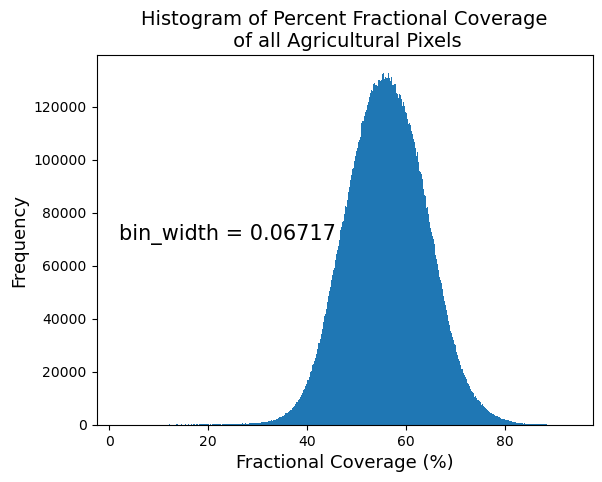

In [24]:
### plot histogram of fractional coverage agricultural area
non_nan_array = np.concatenate([array[~np.isnan(array)] for array in agriPercent_fraction_dict.values()])

Q75 = np.quantile(non_nan_array, 0.75)
Q25 = np.quantile(non_nan_array, 0.25)
optbin = 2.1 * (Q75 - Q25) / (len(non_nan_array)**(1/3))

plt.plot(figsize=(7,7))
plt.hist(non_nan_array,
         bins = np.arange(min(non_nan_array), max(non_nan_array) + optbin, optbin))

plt.title('Histogram of Percent Fractional Coverage\n of all Agricultural Pixels', fontsize = 14)
plt.xlabel('Fractional Coverage (%)', fontsize = 13)
plt.ylabel('Frequency', fontsize = 13)
xmin, xmax, ymin, ymax = plt.axis()
plt.text(xmax*0.02, ymax*0.5, f'bin_width = {np.round(optbin, 5)}', fontsize = 15)

;

In [25]:
np.mean(non_nan_array)

56.13664891331289

In [26]:
np.max(non_nan_array)

93.16558557267122

In [27]:
np.min(non_nan_array)

2.0195170376974203

## 9.4 Examine Erban and Gorelick (2016) maps

In [28]:
### Repeat Erban and Gorelick (2016) thresholding 

# Read the max ndvi composite
max_ndvi_folder = 'MODIS Max NDVI Composite Jan-Mar 2001-2019'
max_ndvi_file_list = [file for file in os.listdir(max_ndvi_folder) 
                      if file.endswith('.tif') and '2Pro' in file and
                      '2000' not in file and '2020' not in file]

# initialize variable for storage
max_image_date_list = []
max_image_NDVI_list = []


for filename in max_ndvi_file_list:
    max_ndvi_path = os.path.join(max_ndvi_folder, filename)
    date = filename[-26:-4]
    with rasterio.open(max_ndvi_path) as img:
        max_DN_array = img.read(1).astype('float64')
        
        # process nodata value (nodata and -3000)
        max_DN_array[max_DN_array == -3000] = np.nan
        max_DN_array[max_DN_array == img.nodata] = np.nan

        # scale DN to index value
        max_NDVI_array = max_DN_array * 0.0001
        
        # store date and NDVI array
        max_image_date_list.append(date)
        max_image_NDVI_list.append(max_NDVI_array)

        # read profile
        img_profile = img.profile

# stack NDVI array
max_stacked_NDVI_MODIS = np.stack(max_image_NDVI_list, axis = 0) # shape now is (date, row, column)

# select against white space
# iterate through row
for row in np.arange(max_stacked_NDVI_MODIS.shape[1]):
    # iterate through column
    for col in np.arange(max_stacked_NDVI_MODIS.shape[2]):
        # for white space, replace with np.nan
        if np.nansum(max_stacked_NDVI_MODIS[:, row, col]) == 0:
            max_stacked_NDVI_MODIS[:, row, col] = np.full_like(max_stacked_NDVI_MODIS[:, row, col], np.nan)

### Perform thresholding of 0.55
threshold_max_stacked_NDVI_MODIS = max_stacked_NDVI_MODIS.copy()
threshold_max_stacked_NDVI_MODIS[threshold_max_stacked_NDVI_MODIS < 0.55] = np.nan
threshold_max_stacked_NDVI_MODIS[threshold_max_stacked_NDVI_MODIS >= 0.55] = 1

### obtain area in km
threshold_max_stacked_NDVI_MODIS_area =  threshold_max_stacked_NDVI_MODIS.copy()
threshold_max_stacked_NDVI_MODIS_area = threshold_max_stacked_NDVI_MODIS_area * MODIS_pixel_area

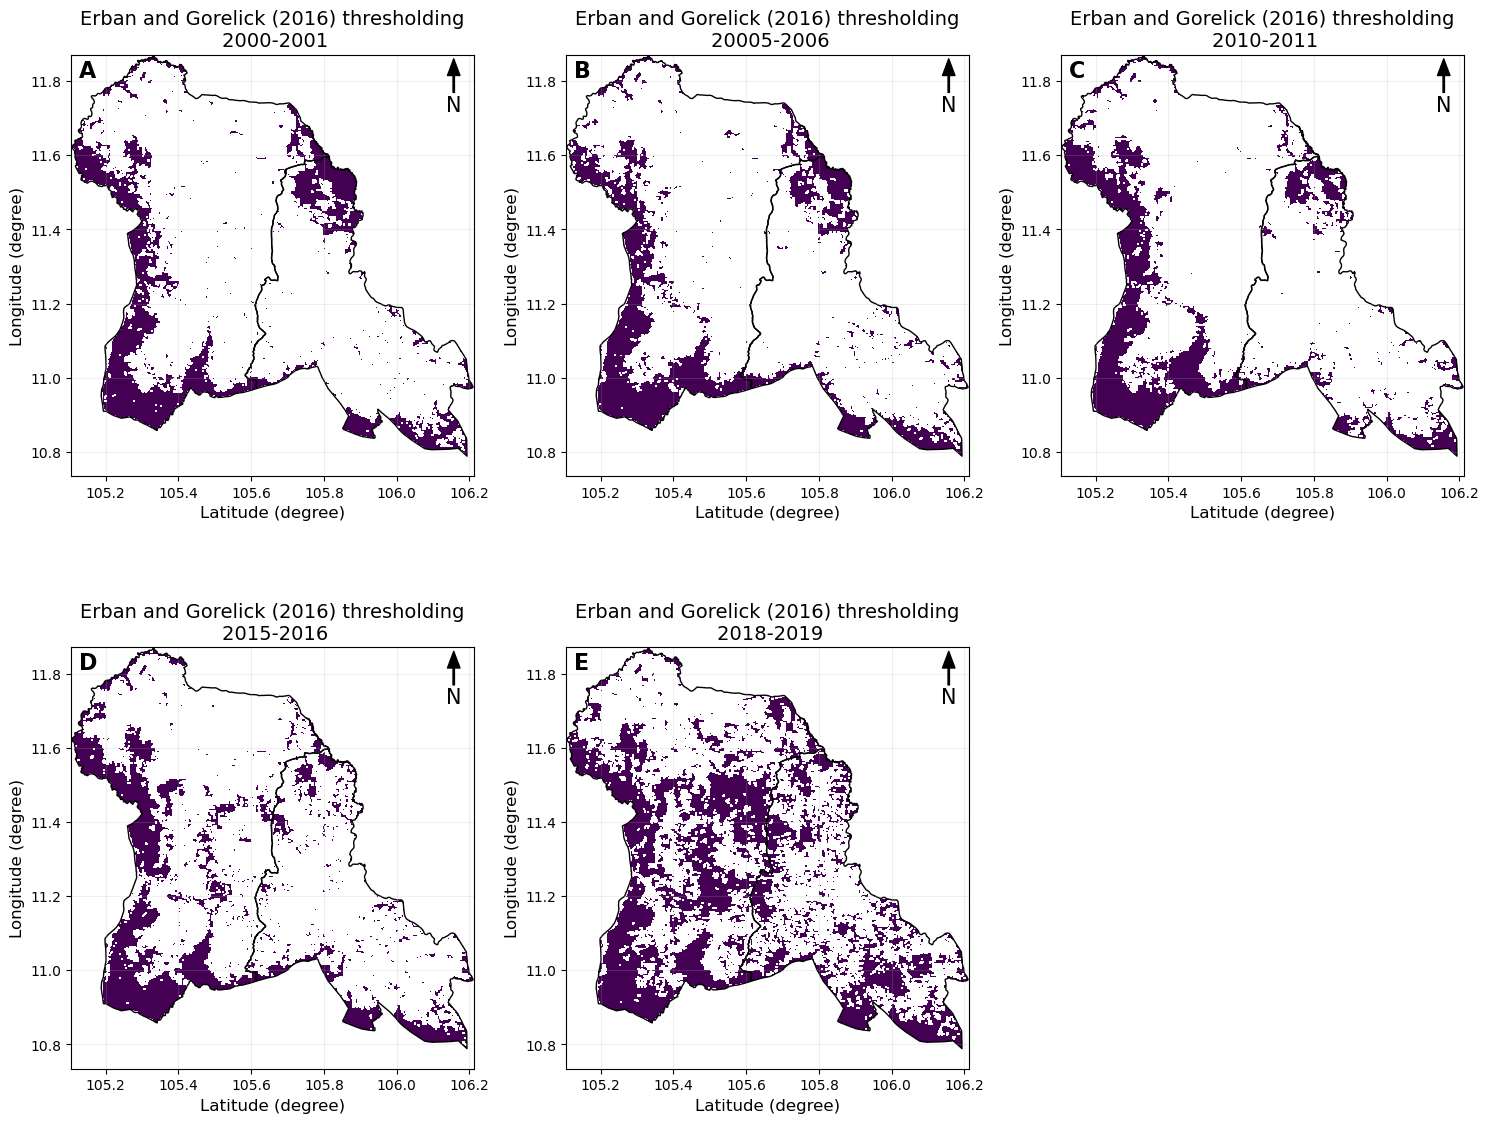

In [29]:
### plot Erban and Gorelick (2016) replication

# prepare boundary
# read shapefile
study_boundary = gpd.read_file('Study Area Boundary Polygon\Double Province Boundary\Province_Boundary.shp')
# Reproject to EPSG 4326 (WGS 84)
study_boundary = study_boundary.to_crs(epsg=4326)

# plot
fig, ax = plt.subplots(2, 3, figsize = (15, 12))
ax = ax.flatten()

# 2000-2001
show(threshold_max_stacked_NDVI_MODIS_area[0], ax = ax[0], transform= img_profile['transform'])
# 2005-2006
show(threshold_max_stacked_NDVI_MODIS_area[5], ax = ax[1], transform= img_profile['transform'])
# 2010-2011
show(threshold_max_stacked_NDVI_MODIS_area[10], ax = ax[2], transform= img_profile['transform'])
# 2015-2016
show(threshold_max_stacked_NDVI_MODIS_area[15], ax = ax[3], transform= img_profile['transform'])
# 2018 - 2019
show(threshold_max_stacked_NDVI_MODIS_area[-1], ax = ax[4], transform= img_profile['transform'])

# remove last subplot
ax[5].remove()

# innitialize lable and title
labels = ['A', 'B', 'C', 'D', 'E']
title_list = ['2000-2001', '20005-2006', '2010-2011', '2015-2016','2018-2019']
for index in np.arange(5):
    ax[index].set_title(f'Erban and Gorelick (2016) thresholding\n {title_list[index]}', fontsize = 14)
    ax[index].set_ylabel('Longitude (degree)', fontsize = 12)
    ax[index].set_xlabel('Latitude (degree)', fontsize = 12)
    ax[index].grid(alpha = 0.2)
    # add subplot label
    ax[index].text(0.02, 0.99, labels[index], transform=ax[index].transAxes,
                fontsize=16, fontweight='bold', va='top', color='k')

    # add arrow
    x, y, arrow_length = 0.95, 0.99, 0.11
    ax[index].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=1, headwidth=9),
                ha='center', va='center', fontsize=15,
                xycoords=ax[index].transAxes)

    # add study boundary
    study_boundary.plot(ax = ax[index], edgecolor = 'k', facecolor = 'none')

plt.tight_layout()

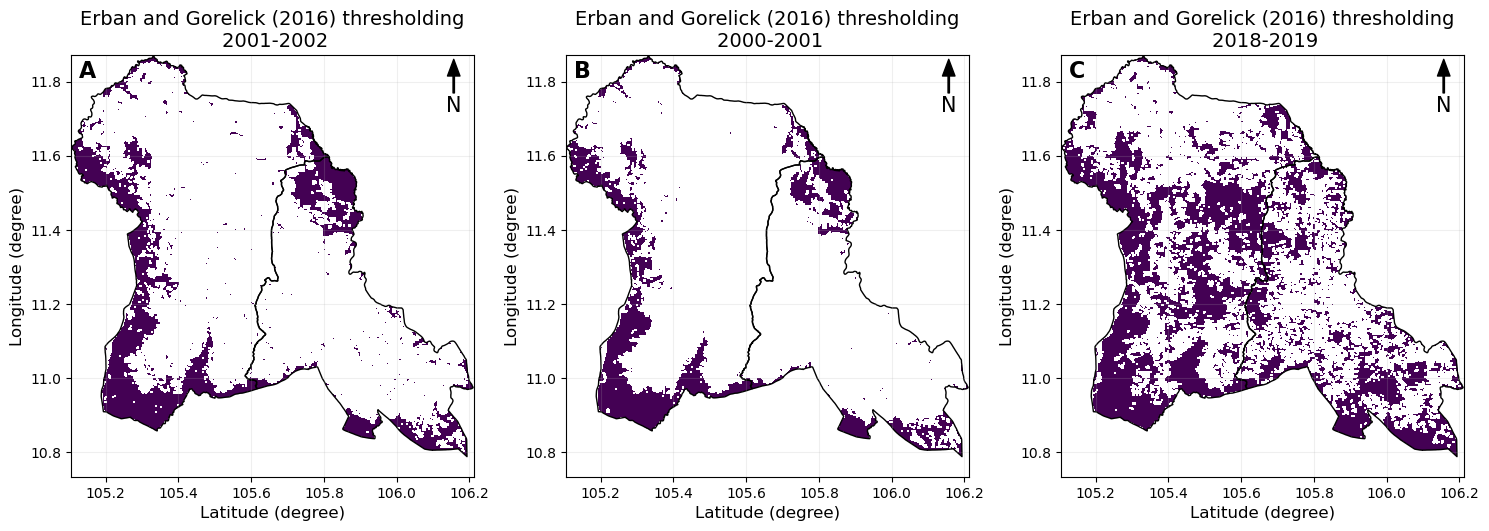

In [30]:
### Plot maximum, median and mean area and date for Erban & Gorelick (2016) replication


### plot Erban and Gorelick (2016) replication

# prepare boundary
# read shapefile
study_boundary = gpd.read_file('Study Area Boundary Polygon\Double Province Boundary\Province_Boundary.shp')
# Reproject to EPSG 4326 (WGS 84)
study_boundary = study_boundary.to_crs(epsg=4326)

# plot
fig, ax = plt.subplots(1, 3, figsize = (15, 12))
ax = ax.flatten()

# min: 2001-2002
show(threshold_max_stacked_NDVI_MODIS_area[0], ax = ax[0], transform= img_profile['transform'])
# 2000-2001
show(threshold_max_stacked_NDVI_MODIS_area[1], ax = ax[1], transform= img_profile['transform'])
# 2018-2019
show(threshold_max_stacked_NDVI_MODIS_area[18], ax = ax[2], transform= img_profile['transform'])


# innitialize lable and title
labels = ['A', 'B', 'C']
title_list = ['2001-2002', '2000-2001', '2018-2019']
for index in np.arange(3):
    ax[index].set_title(f'Erban and Gorelick (2016) thresholding\n {title_list[index]}', fontsize = 14)
    ax[index].set_ylabel('Longitude (degree)', fontsize = 12)
    ax[index].set_xlabel('Latitude (degree)', fontsize = 12)
    ax[index].grid(alpha = 0.2)
    # add subplot label
    ax[index].text(0.02, 0.99, labels[index], transform=ax[index].transAxes,
                fontsize=16, fontweight='bold', va='top', color='k')

    # add arrow
    x, y, arrow_length = 0.95, 0.99, 0.11
    ax[index].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=1, headwidth=9),
                ha='center', va='center', fontsize=15,
                xycoords=ax[index].transAxes)

    # add study boundary
    study_boundary.plot(ax = ax[index], edgecolor = 'k', facecolor = 'none')

plt.tight_layout()

## 9.5 Compare median Agricultural Percentage against Erban and Gorelick (2016)'s median irrigated area (2000-2001) 

In [31]:
# prepare to read min, median and max agricultural percentage's area

median_percentage = '41.75'
area_folder = 'Processed - Agriculture mask regradless IA'
selected_area_filename = [file for file in os.listdir(area_folder) 
                           if file.endswith('.tif') and 
                           median_percentage in file][0]
selected_area_filepaths = os.path.join(area_folder, selected_area_filename) 

# read median 
with rasterio.open(selected_area_filepaths) as img:
    median_array = img.read()
    img_bounds = img.bounds


In [32]:
def array_agreement(EB_array, frac_array):
    
    # create mask
    agree_mask = np.logical_and(~np.isnan(frac_array), ~np.isnan(EB_array))
    frac_array_exclusive_mask = np.logical_and(~agree_mask, ~np.isnan(frac_array))
    EB_array_exclusive_mask = np.logical_and(~agree_mask, ~np.isnan(EB_array))

    # turn mask into np.nan and 1
    agree_mask = agree_mask.astype(np.float64)
    frac_array_exclusive_mask = frac_array_exclusive_mask.astype(np.float64)
    EB_array_exclusive_mask = EB_array_exclusive_mask.astype(np.float64)

    agree_mask[agree_mask == 0] = np.nan
    frac_array_exclusive_mask[frac_array_exclusive_mask == 0] = np.nan
    EB_array_exclusive_mask[EB_array_exclusive_mask == 0] = np.nan
    

    return  EB_array_exclusive_mask, agree_mask, frac_array_exclusive_mask

EB_array_exclusive_mask, agree_mask, frac_array_exclusive_mask = array_agreement(threshold_max_stacked_NDVI_MODIS_area[0], median_array[0])


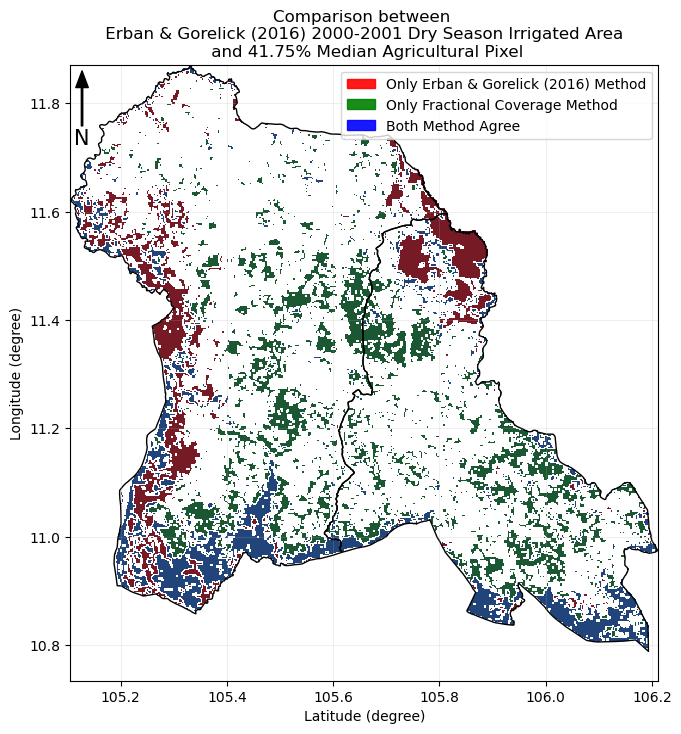

In [33]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8, 8))

# Plotting pixels where both arrays agree in blue
im1 = ax.imshow(agree_mask, cmap='Blues', alpha=0.9, vmin=0, vmax=1, extent=(img_bounds.left, img_bounds.right, img_bounds.bottom, img_bounds.top))

# Plotting pixels exclusive to min_array in red
im2 = ax.imshow(EB_array_exclusive_mask, cmap='Reds', alpha=0.9, vmin=0, vmax=1, extent=(img_bounds.left, img_bounds.right, img_bounds.bottom, img_bounds.top))

# Plotting pixels exclusive to threshold_max_stacked_NDVI_MODIS_area in green
im3 = ax.imshow(frac_array_exclusive_mask, cmap='Greens', alpha=0.9, vmin=0, vmax=1, extent=(img_bounds.left, img_bounds.right, img_bounds.bottom, img_bounds.top))

### aesthetics
ax.set_xlabel('Latitude (degree)')
ax.set_ylabel('Longitude (degree)')
ax.set_title('Comparison between \n Erban & Gorelick (2016) 2000-2001 Dry Season Irrigated Area \n and 41.75% Median Agricultural Pixel')

# Create proxy artists for the legend
legend_elements = [Patch(color='red', alpha=0.9, label='Only Erban & Gorelick (2016) Method'),
                   Patch(color='green', alpha=0.9, label='Only Fractional Coverage Method'),
                   Patch(color='blue', alpha=0.9, label='Both Method Agree')]

# Add legend
ax.legend(handles=legend_elements)
study_boundary.plot(ax= ax, edgecolor = 'k', facecolor = 'none')

# add arrow
x, y, arrow_length = 0.02, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

plt.grid(alpha = 0.2)
plt.show()


## 9.6 Compare Servir Mekong Data to Erban & Gorelick (2016) and fractional coverage 

In [68]:
from rasterio.mask import mask


servir_2001_path = 'Servir Mekong Images\landcover.lc 2001.tif'
with rasterio.open(servir_2001_path) as src:
    
    # clip raster to study boundary
    out_image, out_transform = mask(src, study_boundary.geometry, crop=True)

    # filter for plantations
    plantation_2001_image = out_image.copy()
    plantation_2001_image[plantation_2001_image != 6] = np.nan
    # filter for wetlands
    wetland_2001_image = out_image.copy()
    wetland_2001_image[wetland_2001_image != 14] = np.nan


Text(0.02, 1.03, 'B')

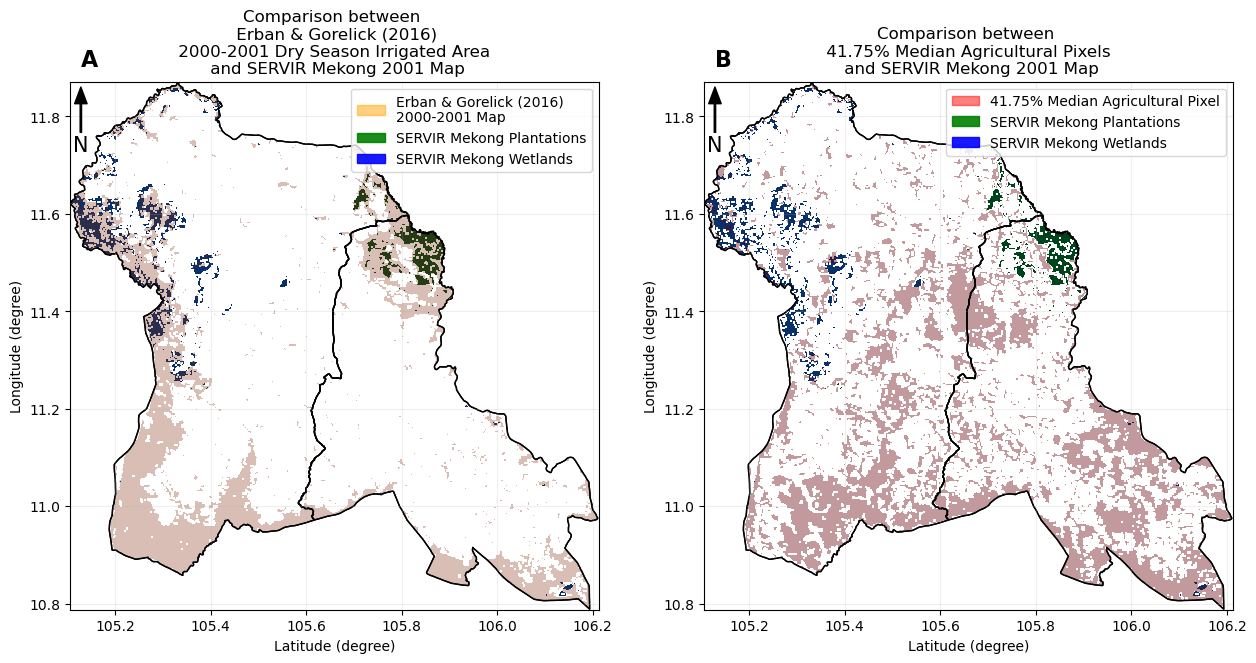

In [125]:
# plot map
fig,ax = plt.subplots(1,2, figsize = (15,10))

# plot for Erban & Gorelick (2016)

study_boundary.plot(ax = ax[0], edgecolor = 'k', facecolor = 'none')
show(plantation_2001_image[0], cmap='Greens_r', transform =out_transform, ax = ax[0])
show(wetland_2001_image[0], cmap='Blues_r', transform =out_transform, ax = ax[0])
show(threshold_max_stacked_NDVI_MODIS_area[0], ax = ax[0], transform= img_profile['transform'], cmap = 'Oranges_r', alpha = 0.3)
### aesthetics
ax[0].set_xlabel('Latitude (degree)')
ax[0].set_ylabel('Longitude (degree)')
ax[0].set_title('Comparison between \n Erban & Gorelick (2016)\n 2000-2001 Dry Season Irrigated Area \n and SERVIR Mekong 2001 Map')

# Create proxy artists for the legend
legend_elements = [Patch(color='orange', alpha=0.5, label='Erban & Gorelick (2016)\n2000-2001 Map'),
                   Patch(color='green', alpha=0.9, label='SERVIR Mekong Plantations'),
                   Patch(color='blue', alpha=0.9, label='SERVIR Mekong Wetlands')
                  ]

# Add legend
ax[0].legend(handles=legend_elements)
study_boundary.plot(ax= ax[0], edgecolor = 'k', facecolor = 'none')

# add arrow
x, y, arrow_length = 0.02, 0.99, 0.11
ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax[0].transAxes)

ax[0].grid(alpha = 0.2)


### plot for agricultural pixel


study_boundary.plot(ax = ax[1], edgecolor = 'k', facecolor = 'none')
show(plantation_2001_image[0], cmap='Greens_r', transform =out_transform, ax = ax[1])
show(wetland_2001_image[0], cmap='Blues_r', transform =out_transform, ax = ax[1])
show(median_array[0], ax = ax[1], transform= img_profile['transform'], cmap = 'Reds_r', alpha = 0.4)
### aesthetics
ax[1].set_xlabel('Latitude (degree)')
ax[1].set_ylabel('Longitude (degree)')
ax[1].set_title('Comparison between \n 41.75% Median Agricultural Pixels \n and SERVIR Mekong 2001 Map')

# Create proxy artists for the legend
legend_elements = [Patch(color='red', alpha=0.5, label='41.75% Median Agricultural Pixel'),
                   Patch(color='green', alpha=0.9, label='SERVIR Mekong Plantations'),
                   Patch(color='blue', alpha=0.9, label='SERVIR Mekong Wetlands')
                  ]

# Add legend
ax[1].legend(handles=legend_elements)
study_boundary.plot(ax= ax[1], edgecolor = 'k', facecolor = 'none')

# add arrow
x, y, arrow_length = 0.02, 0.99, 0.11
ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax[1].transAxes)

ax[1].grid(alpha = 0.2)

# add subplot labels
ax[0].text(0.02, 1.03, "A", transform=ax[0].transAxes, fontsize=16, fontweight='bold')
ax[1].text(0.02, 1.03, "B", transform=ax[1].transAxes, fontsize=16, fontweight='bold')

